<a href="https://colab.research.google.com/github/lindasafitri09-dotcom/SKRIPSI/blob/main/FINE_TUNE_VINFAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python         (KODE INI DIPAKAI UNTUK MENGUKUR F1 SCORE )

# Python version of the evaluation script from CoNLL'00-

# Intentional differences:
# - accept any space as delimiter by default
# - optional file argument (default STDIN)
# - option to set boundary (-b argument)
# - LaTeX output (-l argument) not supported
# - raw tags (-r argument) not supported

import sys
import re
from collections import defaultdict, namedtuple

Metrics = namedtuple('Metrics', 'tp fp fn prec rec fscore')

class EvalCounts(object):
    def __init__(self):
        self.correct_chunk = 0    # number of correctly identified chunks
        self.correct_tags = 0     # number of correct chunk tags
        self.found_correct = 0    # number of chunks in corpus
        self.found_guessed = 0    # number of identified chunks
        self.token_counter = 0    # token counter (ignores sentence breaks)

        # counts by type
        self.t_correct_chunk = defaultdict(int)
        self.t_found_correct = defaultdict(int)
        self.t_found_guessed = defaultdict(int)

###
# Evaluate Function
###
def parse_tag(t):
    m = re.match(r'^([^-]*)-(.*)$', t)
    return m.groups() if m else (t, '')

def start_of_chunk(prev_tag, tag, prev_type, type_):
    # check if a chunk started between the previous and current word
    # arguments: previous and current chunk tags, previous and current types
    chunk_start = False

    if tag == 'B': chunk_start = True
    if tag == 'S': chunk_start = True

    if prev_tag == 'E' and tag == 'E': chunk_start = True
    if prev_tag == 'E' and tag == 'I': chunk_start = True
    if prev_tag == 'S' and tag == 'E': chunk_start = True
    if prev_tag == 'S' and tag == 'I': chunk_start = True
    if prev_tag == 'O' and tag == 'E': chunk_start = True
    if prev_tag == 'O' and tag == 'I': chunk_start = True

    if tag != 'O' and tag != '.' and prev_type != type_:
        chunk_start = True

    # these chunks are assumed to have length 1
    if tag == '[': chunk_start = True
    if tag == ']': chunk_start = True

    return chunk_start

def end_of_chunk(prev_tag, tag, prev_type, type_):
    # check if a chunk ended between the previous and current word
    # arguments: previous and current chunk tags, previous and current types
    chunk_end = False

    if prev_tag == 'E': chunk_end = True
    if prev_tag == 'S': chunk_end = True

    if prev_tag == 'B' and tag == 'B': chunk_end = True
    if prev_tag == 'B' and tag == 'S': chunk_end = True
    if prev_tag == 'B' and tag == 'O': chunk_end = True
    if prev_tag == 'I' and tag == 'B': chunk_end = True
    if prev_tag == 'I' and tag == 'S': chunk_end = True
    if prev_tag == 'I' and tag == 'O': chunk_end = True

    if prev_tag != 'O' and prev_tag != '.' and prev_type != type_:
        chunk_end = True

    # these chunks are assumed to have length 1
    if prev_tag == ']': chunk_end = True
    if prev_tag == '[': chunk_end = True

    return chunk_end

def evaluate_fn(guessed, correct, last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts):
    guessed, guessed_type = parse_tag(guessed)
    correct, correct_type = parse_tag(correct)

    end_correct = end_of_chunk(last_correct, correct,
                               last_correct_type, correct_type)
    end_guessed = end_of_chunk(last_guessed, guessed,
                               last_guessed_type, guessed_type)
    start_correct = start_of_chunk(last_correct, correct,
                                   last_correct_type, correct_type)
    start_guessed = start_of_chunk(last_guessed, guessed,
                                   last_guessed_type, guessed_type)

    if in_correct:
        if (end_correct and end_guessed and
            last_guessed_type == last_correct_type):
            in_correct = False
            counts.correct_chunk += 1
            counts.t_correct_chunk[last_correct_type] += 1
        elif (end_correct != end_guessed or guessed_type != correct_type):
            in_correct = False

    if start_correct and start_guessed and guessed_type == correct_type:
        in_correct = True

    if start_correct:
        counts.found_correct += 1
        counts.t_found_correct[correct_type] += 1
    if start_guessed:
        counts.found_guessed += 1
        counts.t_found_guessed[guessed_type] += 1
    if correct == guessed and guessed_type == correct_type:
        counts.correct_tags += 1
    counts.token_counter += 1

    last_guessed = guessed
    last_correct = correct
    last_guessed_type = guessed_type
    last_correct_type = correct_type

    return last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts

def evaluate(hyps_list, labels_list):
    counts = EvalCounts()
    num_features = None       # number of features per line
    in_correct = False        # currently processed chunks is correct until now
    last_correct = 'O'        # previous chunk tag in corpus
    last_correct_type = ''    # type of previously identified chunk tag
    last_guessed = 'O'        # previously identified chunk tag
    last_guessed_type = ''    # type of previous chunk tag in corpus

    for hyps, labels in zip(hyps_list, labels_list):
        for hyp, label in zip(hyps, labels):
            step_result = evaluate_fn(hyp, label, last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts)
            last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts = step_result
        # Boundary between sentence
        step_result = evaluate_fn('O', 'O', last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts)
        last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts = step_result

    if in_correct:
        counts.correct_chunk += 1
        counts.t_correct_chunk[last_correct_type] += 1

    return counts

###
# Calculate Metrics Function
###
def uniq(iterable):
    seen = set()
    return [i for i in iterable if not (i in seen or seen.add(i))]

def calculate_metrics(correct, guessed, total):
    tp, fp, fn = correct, guessed-correct, total-correct
    p = 0 if tp + fp == 0 else 1.*tp / (tp + fp)
    r = 0 if tp + fn == 0 else 1.*tp / (tp + fn)
    f = 0 if p + r == 0 else (2 * p * r) / (p + r)
    return Metrics(tp, fp, fn, p, r, f)

def metrics(counts):
    c = counts
    overall = calculate_metrics(
        c.correct_chunk, c.found_guessed, c.found_correct
    )
    by_type = {}
    for t in uniq(list(c.t_found_correct.keys()) + list(c.t_found_guessed.keys())):
        by_type[t] = calculate_metrics(
            c.t_correct_chunk[t], c.t_found_guessed[t], c.t_found_correct[t]
        )
    return overall, by_type
    return overall

###
# Main Function
###
def conll_evaluation(hyps_list, labels_list):
    counts = evaluate(hyps_list, labels_list)
    overall, by_type = metrics(counts)

    c = counts
    acc = c.correct_tags / c.token_counter
    pre = overall.prec
    rec = overall.rec
    f1 = overall.fscore

    type_macro_pre = 0.0
    type_macro_rec = 0.0
    type_macro_f1 = 0.0
    for k in by_type.keys():
        type_macro_pre += by_type[k].prec
        type_macro_rec += by_type[k].rec
        type_macro_f1 += by_type[k].fscore

    type_macro_pre = type_macro_pre / float(len(by_type))
    type_macro_rec = type_macro_rec / float(len(by_type))
    type_macro_f1 = type_macro_f1 / float(len(by_type))

    return (acc, pre, rec, f1, type_macro_pre, type_macro_rec, type_macro_f1)#!/usr/bin/env python

# Python version of the evaluation script from CoNLL'00-

# Intentional differences:
# - accept any space as delimiter by default
# - optional file argument (default STDIN)
# - option to set boundary (-b argument)
# - LaTeX output (-l argument) not supported
# - raw tags (-r argument) not supported

import sys
import re
from collections import defaultdict, namedtuple

Metrics = namedtuple('Metrics', 'tp fp fn prec rec fscore')

class EvalCounts(object):
    def __init__(self):
        self.correct_chunk = 0    # number of correctly identified chunks
        self.correct_tags = 0     # number of correct chunk tags
        self.found_correct = 0    # number of chunks in corpus
        self.found_guessed = 0    # number of identified chunks
        self.token_counter = 0    # token counter (ignores sentence breaks)

        # counts by type
        self.t_correct_chunk = defaultdict(int)
        self.t_found_correct = defaultdict(int)
        self.t_found_guessed = defaultdict(int)

###
# Evaluate Function
###
def parse_tag(t):
    m = re.match(r'^([^-]*)-(.*)$', t)
    return m.groups() if m else (t, '')

def start_of_chunk(prev_tag, tag, prev_type, type_):
    # check if a chunk started between the previous and current word
    # arguments: previous and current chunk tags, previous and current types
    chunk_start = False

    if tag == 'B': chunk_start = True
    if tag == 'S': chunk_start = True

    if prev_tag == 'E' and tag == 'E': chunk_start = True
    if prev_tag == 'E' and tag == 'I': chunk_start = True
    if prev_tag == 'S' and tag == 'E': chunk_start = True
    if prev_tag == 'S' and tag == 'I': chunk_start = True
    if prev_tag == 'O' and tag == 'E': chunk_start = True
    if prev_tag == 'O' and tag == 'I': chunk_start = True

    if tag != 'O' and tag != '.' and prev_type != type_:
        chunk_start = True

    # these chunks are assumed to have length 1
    if tag == '[': chunk_start = True
    if tag == ']': chunk_start = True

    return chunk_start

def end_of_chunk(prev_tag, tag, prev_type, type_):
    # check if a chunk ended between the previous and current word
    # arguments: previous and current chunk tags, previous and current types
    chunk_end = False

    if prev_tag == 'E': chunk_end = True
    if prev_tag == 'S': chunk_end = True

    if prev_tag == 'B' and tag == 'B': chunk_end = True
    if prev_tag == 'B' and tag == 'S': chunk_end = True
    if prev_tag == 'B' and tag == 'O': chunk_end = True
    if prev_tag == 'I' and tag == 'B': chunk_end = True
    if prev_tag == 'I' and tag == 'S': chunk_end = True
    if prev_tag == 'I' and tag == 'O': chunk_end = True

    if prev_tag != 'O' and prev_tag != '.' and prev_type != type_:
        chunk_end = True

    # these chunks are assumed to have length 1
    if prev_tag == ']': chunk_end = True
    if prev_tag == '[': chunk_end = True

    return chunk_end

def evaluate_fn(guessed, correct, last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts):
    guessed, guessed_type = parse_tag(guessed)
    correct, correct_type = parse_tag(correct)

    end_correct = end_of_chunk(last_correct, correct,
                               last_correct_type, correct_type)
    end_guessed = end_of_chunk(last_guessed, guessed,
                               last_guessed_type, guessed_type)
    start_correct = start_of_chunk(last_correct, correct,
                                   last_correct_type, correct_type)
    start_guessed = start_of_chunk(last_guessed, guessed,
                                   last_guessed_type, guessed_type)

    if in_correct:
        if (end_correct and end_guessed and
            last_guessed_type == last_correct_type):
            in_correct = False
            counts.correct_chunk += 1
            counts.t_correct_chunk[last_correct_type] += 1
        elif (end_correct != end_guessed or guessed_type != correct_type):
            in_correct = False

    if start_correct and start_guessed and guessed_type == correct_type:
        in_correct = True

    if start_correct:
        counts.found_correct += 1
        counts.t_found_correct[correct_type] += 1
    if start_guessed:
        counts.found_guessed += 1
        counts.t_found_guessed[guessed_type] += 1
    if correct == guessed and guessed_type == correct_type:
        counts.correct_tags += 1
    counts.token_counter += 1

    last_guessed = guessed
    last_correct = correct
    last_guessed_type = guessed_type
    last_correct_type = correct_type

    return last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts

def evaluate(hyps_list, labels_list):
    counts = EvalCounts()
    num_features = None       # number of features per line
    in_correct = False        # currently processed chunks is correct until now
    last_correct = 'O'        # previous chunk tag in corpus
    last_correct_type = ''    # type of previously identified chunk tag
    last_guessed = 'O'        # previously identified chunk tag
    last_guessed_type = ''    # type of previous chunk tag in corpus

    for hyps, labels in zip(hyps_list, labels_list):
        for hyp, label in zip(hyps, labels):
            step_result = evaluate_fn(hyp, label, last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts)
            last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts = step_result
        # Boundary between sentence
        step_result = evaluate_fn('O', 'O', last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts)
        last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts = step_result

    if in_correct:
        counts.correct_chunk += 1
        counts.t_correct_chunk[last_correct_type] += 1

    return counts

###
# Calculate Metrics Function
###
def uniq(iterable):
    seen = set()
    return [i for i in iterable if not (i in seen or seen.add(i))]

def calculate_metrics(correct, guessed, total):
    tp, fp, fn = correct, guessed-correct, total-correct
    p = 0 if tp + fp == 0 else 1.*tp / (tp + fp)
    r = 0 if tp + fn == 0 else 1.*tp / (tp + fn)
    f = 0 if p + r == 0 else (2 * p * r) / (p + r)
    return Metrics(tp, fp, fn, p, r, f)

def metrics(counts):
    c = counts
    overall = calculate_metrics(
        c.correct_chunk, c.found_guessed, c.found_correct
    )
    by_type = {}
    for t in uniq(list(c.t_found_correct.keys()) + list(c.t_found_guessed.keys())):
        by_type[t] = calculate_metrics(
            c.t_correct_chunk[t], c.t_found_guessed[t], c.t_found_correct[t]
        )
    return overall, by_type
    return overall

###
# Main Function
###
def conll_evaluation(hyps_list, labels_list):
    counts = evaluate(hyps_list, labels_list)
    overall, by_type = metrics(counts)

    c = counts
    acc = c.correct_tags / c.token_counter
    pre = overall.prec
    rec = overall.rec
    f1 = overall.fscore

    type_macro_pre = 0.0
    type_macro_rec = 0.0
    type_macro_f1 = 0.0
    for k in by_type.keys():
        type_macro_pre += by_type[k].prec
        type_macro_rec += by_type[k].rec
        type_macro_f1 += by_type[k].fscore

    type_macro_pre = type_macro_pre / float(len(by_type))
    type_macro_rec = type_macro_rec / float(len(by_type))
    type_macro_f1 = type_macro_f1 / float(len(by_type))

    return (acc, pre, rec, f1, type_macro_pre, type_macro_rec, type_macro_f1)

In [ ]:
import logging           #(MEMBUAT MODEL BERT UNTUK MEMPREDIKSI SENTIMEN DARI BEBERAPA ASPEK SEKALIGUS)
import math
import os

import torch
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss

from transformers import BertPreTrainedModel, BertModel, BertConfig
from transformers import AutoTokenizer, AutoConfig


class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels_list

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifiers = nn.ModuleList([nn.Linear(config.hidden_size, num_label) for num_label in self.num_labels])

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        subword_to_word_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`, defaults to :obj:`None`):
            Labels for computing the token classification loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.

    Returns:
        :obj:`tuple(torch.FloatTensor)` comprising various elements depending on the configuration (:class:`~transformers.BertConfig`) and inputs:
        loss (:obj:`torch.FloatTensor` of shape :obj:`(1,)`, `optional`, returned when ``labels`` is provided) :
            Classification loss.
        scores (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, config.num_labels)`)
            Classification scores (before SoftMax).
        hidden_states (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_hidden_states=True``):
            Tuple of :obj:`torch.FloatTensor` (one for the output of the embeddings + one for the output of each layer)
            of shape :obj:`(batch_size, sequence_length, hidden_size)`.

            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        attentions (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_attentions=True``):
            Tuple of :obj:`torch.FloatTensor` (one for each layer) of shape
            :obj:`(batch_size, num_heads, sequence_length, sequence_length)`.

            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
        """

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output = self.dropout(outputs[1])
        logits = []
        for classifier in self.classifiers:
            logit = classifier(sequence_output)
            logits.append(logit)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            total_loss = 0
            for i, (logit, num_label) in enumerate(zip(logits, self.num_labels)):
                label = labels[:,i]
                loss = loss_fct(logit.view(-1, num_label), label.view(-1))
                total_loss += loss
            outputs = (total_loss,) + outputs

        return outputs  # (loss), scores, (hidden_states), (attentions)

if __name__ == '__main__':
    x = torch.LongTensor([[301,302,303,304]])
    y = torch.LongTensor([[0,1,0,1,0,1]])

    print("BertForMultiLabelClassification")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    config = AutoConfig.from_pretrained("bert-base-uncased")
    config.num_labels_list = [3,3,3,3,3,3]
    model = BertForMultiLabelClassification.from_pretrained("bert-base-uncased", config=config)
    output = model(x, labels=y)
    print(output[0], output[1])




BertForMultiLabelClassification


Some weights of BertForMultiLabelClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifiers.0.bias', 'classifiers.0.weight', 'classifiers.1.bias', 'classifiers.1.weight', 'classifiers.2.bias', 'classifiers.2.weight', 'classifiers.3.bias', 'classifiers.3.weight', 'classifiers.4.bias', 'classifiers.4.weight', 'classifiers.5.bias', 'classifiers.5.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor(7.4253, grad_fn=<AddBackward0>) [tensor([[-0.5044,  0.5295, -0.2799]], grad_fn=<AddmmBackward0>), tensor([[ 0.2352, -0.1070,  0.2383]], grad_fn=<AddmmBackward0>), tensor([[-0.1710, -0.0991,  0.4671]], grad_fn=<AddmmBackward0>), tensor([[ 0.0893,  0.2931, -0.6413]], grad_fn=<AddmmBackward0>), tensor([[-0.2283,  0.0612,  0.0910]], grad_fn=<AddmmBackward0>), tensor([[ 0.1293,  0.1992, -0.1097]], grad_fn=<AddmmBackward0>)]


In [ ]:
import torch

###
# Forward Function      (MENGIRIM DATA KE MODEL BERT)
###

# Forward function for sequence classification
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data

    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)

    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])

    return loss, list_hyp, list_label

# Forward function for word classification
def forward_word_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 4:
        (subword_batch, mask_batch, subword_to_word_indices_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 5:
        (subword_batch, mask_batch, token_type_batch, subword_to_word_indices_batch, label_batch) = batch_data

    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    subword_to_word_indices_batch = torch.LongTensor(subword_to_word_indices_batch)
    label_batch = torch.LongTensor(label_batch)

    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        subword_to_word_indices_batch = subword_to_word_indices_batch.cuda()
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, subword_to_word_indices_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]

    # generate prediction & label list
    list_hyps = []
    list_labels = []
    hyps_list = torch.topk(logits, k=1, dim=-1)[1].squeeze(dim=-1)
    for i in range(len(hyps_list)):
        hyps, labels = hyps_list[i].tolist(), label_batch[i].tolist()
        list_hyp, list_label = [], []
        for j in range(len(hyps)):
            if labels[j] == -100:
                break
            else:
                list_hyp.append(i2w[hyps[j]])
                list_label.append(i2w[labels[j]])
        list_hyps.append(list_hyp)
        list_labels.append(list_label)

    return loss, list_hyps, list_labels

# Forward function for sequence multilabel classification
def forward_sequence_multi_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data

    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)

    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2] # logits list<tensor(bs, num_label)> ~ list of batch prediction per class

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = [torch.topk(logit, 1)[1] for logit in logits] # list<tensor(bs)>
    batch_size = label_batch.shape[0]
    num_label = len(hyp)
    for i in range(batch_size):
        hyps = []
        labels = label_batch[i,:].cpu().numpy().tolist()
        for j in range(num_label):
            hyps.append(hyp[j][i].item())
        list_hyp.append([i2w[hyp] for hyp in hyps])
        list_label.append([i2w[label] for label in labels])

    return loss, list_hyp, list_label


In [ ]:
import itertools                   #(MENGHITUNG SCORE EVALUASI MODEL ABSA)
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
#from .conlleval import conll_evaluation

def absa_metrics_fn(list_hyp, list_label):
    # hyp and label are both list (multi label), flatten the list
    list_hyp = list(itertools.chain.from_iterable(list_hyp))
    list_label = list(itertools.chain.from_iterable(list_label))

    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics

In [ ]:
import numpy as np         #(MENYIAPKAN DATASET ABSA VINFAST)
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

#####
# ABSA Vinfast (Ulasan via kolom `preprocessed`)
#####
class AspectBasedSentimentAnalysisVinfastDataset(Dataset):
    # Static constant variable
    ASPECT_DOMAIN = ['performa', 'desain', 'teknologi', 'harga', 'baterai', 'kenyamanan']
    LABEL2INDEX = {'negatif': 0, 'netral': 1, 'positif': 2}
    INDEX2LABEL = {0: 'negatif', 1: 'netral', 2: 'positif'}
    NUM_LABELS = [3, 3, 3, 3, 3]
    NUM_ASPECTS = 6

    # Update __init__ to correctly call load_dataset and accept lowercase
    def __init__(self, dataset_path, tokenizer, lowercase=False, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path, lowercase=lowercase) # Pass lowercase to load_dataset
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token

    # Corrected indentation for load_dataset
    def load_dataset(self, path, lowercase=False):
        # Added delimiter and low_memory=False to handle potential parsing issues
        df = pd.read_csv(path, delimiter=';', low_memory=False)
        # Create a mapping for expected sentiment strings to their processed form
        sentiment_mapping = {
            'negatif': 'negatif',
            'netral': 'netral',
            'positif': 'positif',
            'pos': 'positif' # Handle the 'pos' case explicitly
        }
        if lowercase:
            # Add lowercase versions to the mapping
            lower_sentiment_mapping = {k.lower(): v for k, v in sentiment_mapping.items()}
            sentiment_mapping.update(lower_sentiment_mapping)

        for aspect in self.ASPECT_DOMAIN:
            def map_sentiment(sen):
                processed_sen = str(sen).lower() if lowercase else str(sen)
                # Look up the processed sentiment in the mapping
                mapped_sen = sentiment_mapping.get(processed_sen, processed_sen) # Default to processed_sen if not in mapping
                try:
                    return self.LABEL2INDEX[mapped_sen]
                except KeyError:
                    print(f"KeyError: '{mapped_sen}' not found in LABEL2INDEX for aspect '{aspect}'. Original value: '{sen}', Processed value: '{processed_sen}'")
                    raise # Re-raise the error to see the traceback
            df[aspect] = df[aspect].apply(map_sentiment)
        return df

    # Add the __len__ method
    def __len__(self):
        return len(self.data)

    # You also need to implement __getitem__ for the DataLoader to iterate over the dataset
    # This is a minimal implementation assuming your data is already processed and stored in self.data
    # You will likely need to add tokenization and label extraction logic here
    # Corrected indentation for __getitem__
    def __getitem__(self, idx):
        # Example: Assuming self.data is a pandas DataFrame with a 'text' column and aspect columns
        text = self.data.iloc[idx]['preprocessed'] # Assuming 'preprocessed' column exists and contains the text
        labels = self.data.iloc[idx][self.ASPECT_DOMAIN].values.tolist()

        # Ensure text is a string before tokenizing
        text = str(text)

        # Tokenize the text - adjust according to your specific needs
        encoded_inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        subwords = encoded_inputs['input_ids'].squeeze()
        mask = encoded_inputs['attention_mask'].squeeze()

        # Assuming labels are already in the correct integer format from load_dataset
        label = torch.LongTensor(labels)

        # Return the tokenized input, attention mask, and labels
        return subwords, mask, label, text # Returning raw_seq (original text) as the last element

class AspectBasedSentimentAnalysisDataLoader(DataLoader):
    def __init__(self, dataset, max_seq_len=512, device='cpu', *args, **kwargs): # Added device argument
        super(AspectBasedSentimentAnalysisDataLoader, self).__init__(dataset=dataset, *args, **kwargs)
        self.num_aspects = dataset.NUM_ASPECTS
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        self.device = device # Store device

    def _collate_fn(self, batch):
        batch_size = len(batch)
        # The batch now contains (subwords, mask, label, raw_seq)
        subword_batch = [item[0] for item in batch]
        mask_batch = [item[1] for item in batch]
        label_batch = [item[2] for item in batch]
        seq_list = [item[3] for item in batch]

        # Pad the sequences in the batch
        max_seq_len = max(len(seq) for seq in subword_batch)
        max_seq_len = min(self.max_seq_len, max_seq_len)

        # Create tensors directly on the specified device
        padded_subword_batch = torch.zeros((batch_size, max_seq_len), dtype=torch.int64, device=self.device)
        padded_mask_batch = torch.zeros((batch_size, max_seq_len), dtype=torch.float32, device=self.device)
        padded_label_batch = torch.zeros((batch_size, self.num_aspects), dtype=torch.int64, device=self.device)


        for i in range(batch_size):
            seq_len = len(subword_batch[i])
            # Ensure source tensors are on the same device before copying
            padded_subword_batch[i, :seq_len] = subword_batch[i][:max_seq_len].to(self.device)
            padded_mask_batch[i, :seq_len] = mask_batch[i][:max_seq_len].to(self.device)
            padded_label_batch[i, :] = label_batch[i].to(self.device)


        return padded_subword_batch, padded_mask_batch, padded_label_batch, seq_list

In [ ]:
# %%             #(MENYIAPKAN LIBRARY UNTUK MELATI MODEL BERT)
import os
#import os, sys
#sys.path.append('../')
#os.chdir('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertTokenizer, BertConfig, BertForPreTraining
from nltk.tokenize import TweetTokenizer, word_tokenize

#from modules.multi_label_classification import BertForMultiLabelClassification
#from utils.forward_fn import forward_sequence_multi_classification
#from utils.metrics import absa_metrics_fn
#from utils.data_utils import AspectBasedSentimentAnalysisTeslaDataset, AspectBasedSentimentAnalysisDataLoader

In [ ]:
###                                 #(PELATIHAN MODEL AGAR LEBIH RAPIH)
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
# Set random seed                   (MENYIAPKAN DATA DAN PERANGKAT SEBELUM PELATIHAN MODEL DIMULAI)
set_seed(26092020)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset_path = 'data_mobil_train.csv'
valid_dataset_path = 'data_mobil_val.csv'
test_dataset_path = 'data_mobil_test.csv'

train_dataset = AspectBasedSentimentAnalysisVinfastDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = AspectBasedSentimentAnalysisVinfastDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = AspectBasedSentimentAnalysisVinfastDataset(test_dataset_path, tokenizer, lowercase=True)

# Pass the device to the DataLoader
train_loader = AspectBasedSentimentAnalysisDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=16, num_workers=2, shuffle=True, device=device)
# Corrected the class name here
valid_loader = AspectBasedSentimentAnalysisDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=16, num_workers=2, shuffle=False, device=device)
test_loader = AspectBasedSentimentAnalysisDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=16, num_workers=2, shuffle=False, device=device)

In [ ]:
import logging   #(MELATIH DAN MEMPREDIKSI SENTIMEN DARI BEBERAPA ASPEK)
import math
import os

import torch
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss

from transformers import BertPreTrainedModel, BertModel, BertConfig
from transformers import AutoTokenizer, AutoConfig


class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        # Ensure config.num_labels_list is a list, even if it has only one element
        self.num_labels = config.num_labels_list if isinstance(config.num_labels_list, list) else [config.num_labels_list]

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # Ensure there is a classifier for each num_label specified in the list
        self.classifiers = nn.ModuleList([nn.Linear(config.hidden_size, num_label) for num_label in self.num_labels])

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        subword_to_word_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        device=None,  # Add device as an argument
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`, defaults to :obj:`None`):
            Labels for computing the token classification loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.

    Returns:
        :obj:`tuple(torch.FloatTensor)` comprising various elements depending on the configuration (:class:`~transformers.BertConfig`) and inputs:
        loss (:obj:`torch.FloatTensor` of shape :obj:`(1,)`, `optional`, returned when ``labels`` is provided) :
            Classification loss.
        scores (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, config.num_labels)`)
            Classification scores (before SoftMax).
        hidden_states (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_hidden_states=True``):
            Tuple of :obj:`torch.FloatTensor` (one for the output of the embeddings + one for the output of each layer)
            of shape :obj:`(batch_size, sequence_length, hidden_size)`.

            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        attentions (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_attentions=True``):
            Tuple of :obj:`torch.FloatTensor` (one for each layer) of shape
            :obj:`(batch_size, num_heads, sequence_length, sequence_length)`.

            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
        """

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        # Use the pooled output for sequence-level classification
        sequence_output = self.dropout(outputs[1])
        logits = []
        for classifier in self.classifiers:
            logit = classifier(sequence_output)
            logits.append(logit)

        # logits is now a list of tensors, where each tensor is (batch_size, num_labels_for_that_classifier)
        # outputs should now be (loss), logits (as a list), (hidden_states), (attentions)
        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            # Use the provided device argument to move labels
            labels = labels.to(device)
            loss_fct = CrossEntropyLoss()
            total_loss = 0
            # Iterate through each classifier's logits and corresponding label column
            for i, logit in enumerate(logits):
                 # Select the i-th column of the labels for the i-th classifier
                label = labels[:,i]
                # Reshape logit to (batch_size * sequence_length, num_labels) and label to (batch_size * sequence_length)
                # For sequence classification, sequence_length is 1 since we are using pooled output
                # So reshape logit to (batch_size, num_labels) and label to (batch_size)
                loss = loss_fct(logit.view(-1, self.num_labels[i]), label.view(-1))
                total_loss += loss
            outputs = (total_loss,) + outputs

        # Return logits as a list of tensors, as expected by forward_sequence_multi_classification
        return outputs  # (loss), logits (list of tensors), (hidden_states), (attentions)

if __name__ == '__main__':
    x = torch.LongTensor([[301,302,303,304]])
    # Corrected example labels for 6 aspects
    y = torch.LongTensor([[0,1,0,1,0,2]])

    print("BertForMultiLabelClassification")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    config = AutoConfig.from_pretrained("bert-base-uncased")
    # Corrected num_labels_list to match the 6 aspects
    config.num_labels_list = [3,3,3,3,3,3]
    model = BertForMultiLabelClassification.from_pretrained("bert-base-uncased", config=config)
    # Ensure labels match the expected shape for 6 aspects in the test case
    y = torch.LongTensor([[0,1,0,1,0,2]]) # Reshaped for 6 labels
    output = model(x, labels=y, device=model.device) # Pass device in test case
    print(output[0], output[1])

BertForMultiLabelClassification


Some weights of BertForMultiLabelClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifiers.0.bias', 'classifiers.0.weight', 'classifiers.1.bias', 'classifiers.1.weight', 'classifiers.2.bias', 'classifiers.2.weight', 'classifiers.3.bias', 'classifiers.3.weight', 'classifiers.4.bias', 'classifiers.4.weight', 'classifiers.5.bias', 'classifiers.5.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor(7.3483, grad_fn=<AddBackward0>) [tensor([[-0.0161,  0.0953,  0.1877]], grad_fn=<AddmmBackward0>), tensor([[-0.0397, -0.0038,  0.4326]], grad_fn=<AddmmBackward0>), tensor([[ 0.0541, -0.0541,  0.0399]], grad_fn=<AddmmBackward0>), tensor([[-0.5536, -0.0125,  0.2666]], grad_fn=<AddmmBackward0>), tensor([[-0.6469, -0.0944,  0.3544]], grad_fn=<AddmmBackward0>), tensor([[-0.0854, -0.4482, -0.1959]], grad_fn=<AddmmBackward0>)]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
model

BertForMultiLabelClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=

In [ ]:
count_param(model)

109496082

In [ ]:
train_dataset_path = 'data_mobil_train.csv'
valid_dataset_path = 'data_mobil_val.csv'
test_dataset_path = 'data_mobil_test.csv'

In [ ]:
train_dataset = AspectBasedSentimentAnalysisVinfastDataset(train_dataset_path, tokenizer, lowercase=True)      #(MENYIAPKAN DATA PELATIHAN)
valid_dataset = AspectBasedSentimentAnalysisVinfastDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = AspectBasedSentimentAnalysisVinfastDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = AspectBasedSentimentAnalysisDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=16, num_workers=2, shuffle=True)
valid_loader = AspectBasedSentimentAnalysisDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=16, num_workers=2, shuffle=False)
test_loader = AspectBasedSentimentAnalysisDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=16, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = AspectBasedSentimentAnalysisVinfastDataset.LABEL2INDEX, AspectBasedSentimentAnalysisVinfastDataset.INDEX2LABEL #(KONVERSI LABEL)
print(w2i)
print(i2w)

{'negatif': 0, 'netral': 1, 'positif': 2}
{0: 'negatif', 1: 'netral', 2: 'positif'}


In [ ]:
text = 'Alangkah lebih baik lg klo beli mobil batrenya desainnya bagus tu dari pada wuling di kelasnya'  #(MEMPREDIKSI SENTIMEN DARI TEXT BERDASARKAN 6 ASPEK)
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
labels = [torch.topk(logit, k=1, dim=-1)[1].squeeze().item() for logit in logits]

print(f'Text: {text}')
for i, label in enumerate(labels):
    print(f'Label `{AspectBasedSentimentAnalysisVinfastDataset.ASPECT_DOMAIN[i]}` : {i2w[label]} ({F.softmax(logits[i], dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Alangkah lebih baik lg klo beli mobil batrenya desainnya bagus tu dari pada wuling di kelasnya
Label `performa` : positif (38.967%)
Label `desain` : negatif (46.241%)
Label `teknologi` : netral (43.031%)
Label `harga` : netral (45.620%)
Label `baterai` : positif (51.226%)
Label `kenyamanan` : negatif (48.679%)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
text = 'Vinfast sedang menggali kuburnya sendiri'  #(MEMPREDIKSI SENTIMEN DARI KALIMAT UNTUK SETIAP ASPEK)
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
labels = [torch.topk(logit, k=1, dim=-1)[1].squeeze().item() for logit in logits]

print(f'Text: {text}')
for i, label in enumerate(labels):
    print(f'Label `{AspectBasedSentimentAnalysisVinfastDataset.ASPECT_DOMAIN[i]}` : {i2w[label]} ({F.softmax(logits[i], dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Vinfast sedang menggali kuburnya sendiri
Label `performa` : netral (40.765%)
Label `desain` : negatif (44.852%)
Label `teknologi` : netral (44.144%)
Label `harga` : netral (45.842%)
Label `baterai` : positif (48.672%)
Label `kenyamanan` : negatif (49.942%)


In [ ]:
text = 'Pernah liat pameran di kemayoran ada vinfast ini build quality dashboard dan doortrimnya ampun deh kasar banget Dari situ aja udah keliatan lah kualitas mobilnya kaya apa Kok bisa banyak yg beli Kemakan reviewer kah' #(MEMPREDIKSI KOMENTAR SETIAP ASPEK)
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
labels = [torch.topk(logit, k=1, dim=-1)[1].squeeze().item() for logit in logits]

print(f'Text: {text}')
for i, label in enumerate(labels):
    print(f'Label `{AspectBasedSentimentAnalysisVinfastDataset.ASPECT_DOMAIN[i]}` : {i2w[label]} ({F.softmax(logits[i], dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Pernah liat pameran di kemayoran ada vinfast ini build quality dashboard dan doortrimnya ampun deh kasar banget Dari situ aja udah keliatan lah kualitas mobilnya kaya apa Kok bisa banyak yg beli Kemakan reviewer kah
Label `performa` : positif (38.446%)
Label `desain` : negatif (45.006%)
Label `teknologi` : netral (43.765%)
Label `harga` : netral (45.418%)
Label `baterai` : positif (50.062%)
Label `kenyamanan` : negatif (46.272%)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)      #(MEYIAPKAN MODEL DAM OPTIMIZER AGAR BISA DI LATIH DI GPU DAN CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [ ]:
import torch   #(UNTUK MELATIH DAN MENGEVALUASI ABSA SELAMA BEBERAPA EPOCH)
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

# Gunakan string untuk device agar konsisten dengan fungsi
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(torch.device(device))  # pastikan model benar-benar pindah ke device

scaler = GradScaler()  # Mixed Precision Training
n_epochs = 15
grad_accumulation_steps = 2  # Mengurangi beban per update
save_checkpoint_every = 5  # Simpan model tiap 5 epoch

# Forward function for sequence multilabel classification
def forward_sequence_multi_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data. From DataLoader collate_fn, batch_data is (padded_subword_batch, padded_mask_batch, padded_label_batch, seq_list)
    # So input_data is (subword_batch, mask_batch), labels_batch is padded_label_batch
    # seq_list is the last element but is not used in the forward pass
    subword_batch, mask_batch, label_batch, seq_list = batch_data

    # Explicitly move subword_batch, mask_batch, and label_batch to the specified device
    # Although DataLoader attempts this, explicit movement here adds robustness
    subword_batch = subword_batch.to(device)
    mask_batch = mask_batch.to(device)
    label_batch = label_batch.to(device)


    # Check if token_type_batch is needed and present (not the case for this dataset)
    token_type_batch = None

    # Forward model
    # Pass only the relevant tensors to the model
    outputs = model(
        input_ids=subword_batch,
        attention_mask=mask_batch,
        token_type_ids=token_type_batch,
        labels=label_batch,
        device=device # Pass device to the model's forward
    )
    loss, logits = outputs[:2] # logits list<tensor(bs, num_label)> ~ list of batch prediction per class

    # generate prediction & label list
    list_hyp = []
    list_label = []
    # Move logits to CPU before processing to avoid potential device issues
    # Each logit is a tensor of shape (batch_size, num_labels_for_that_classifier)
    # We need to take the top 1 predicted label for each sample in the batch for each classifier
    hyp = [torch.topk(logit.cpu(), 1)[1].squeeze(dim=-1) for logit in logits] # list<tensor(bs)>
    batch_size = label_batch.shape[0]
    num_label = len(hyp)
    # Move label_batch to CPU for list conversion
    labels_cpu = label_batch.cpu().numpy().tolist()

    for i in range(batch_size):
        hyps = []
        labels = labels_cpu[i]
        for j in range(num_label):
            # Get the predicted label for the i-th sample from the j-th classifier
            hyps.append(hyp[j][i].item())
        list_hyp.append([i2w[hyp_item] for hyp_item in hyps])
        list_label.append([i2w[label_item] for label_item in labels])


    return loss, list_hyp, list_label


for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    optimizer.zero_grad()

    for i, batch_data in enumerate(train_pbar):
        # batch_data from DataLoader collate_fn is (padded_subword_batch, padded_mask_batch, padded_label_batch, seq_list)
        # All tensors (subword_batch, mask_batch, label_batch) are already on the correct device thanks to the updated DataLoader
        with autocast():  # Mixed precision untuk menghemat memori
            loss, batch_hyp, batch_label = forward_sequence_multi_classification(
                model, batch_data, i2w=i2w, device=device # Pass the full batch_data
            )

        # Gradient accumulation untuk batch kecil
        scaler.scale(loss).backward()

        if (i + 1) % grad_accumulation_steps == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        # Logging training loss
        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description(
            f"(Epoch {epoch+1}) TRAIN LOSS: {total_train_loss/(i+1):.4f} LR: {get_lr(optimizer):.8f}"
        )

    # Calculate train metric
    metrics = absa_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) TRAIN LOSS: {total_train_loss/(i+1):.4f} {metrics_to_string(metrics)} LR: {get_lr(optimizer):.8f}")

    # Save checkpoint setiap beberapa epoch
    if (epoch + 1) % save_checkpoint_every == 0:
        torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")

    # Evaluation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, list_hyp, list_label = 0, [], []
    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))

    for i, batch_data in enumerate(pbar):
        # batch_data from DataLoader collate_fn is (padded_subword_batch, padded_mask_batch, padded_label_batch, seq_list)
        # All tensors (subword_batch, mask_batch, label_batch) are already on the correct device thanks to the updated DataLoader
        with autocast():
            loss, batch_hyp, batch_label = forward_sequence_multi_classification(
                model, batch_data, i2w=i2w, device=device # Pass the full batch_data
            )

        total_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = absa_metrics_fn(list_hyp, list_label)

        pbar.set_description(f"VALID LOSS: {total_loss/(i+1):.4f} {metrics_to_string(metrics)}")

    metrics = absa_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) VALID LOSS: {total_loss/(i+1):.4f} {metrics_to_string(metrics)}")

    # Bersihkan cache GPU setelah setiap epoch
    torch.cuda.empty_cache()

/tmp/ipython-input-2544617402.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed Precision Training
  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
(Epoch 1) TRAIN LOSS: 5.9385 LR: 0.00001000: 100%|██████████| 54/54 [00:18<00:00,  2.90it/s]


(Epoch 1) TRAIN LOSS: 5.9385 ACC:0.55 F1:0.25 REC:0.30 PRE:0.33 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS: 4.4984 ACC:0.92 F1:0.32 REC:0.32 PRE:0.33:   6%|▋         | 1/16 [00:00<00:03,  4.37it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS: 4.5823 

(Epoch 1) VALID LOSS: 4.5010 ACC:0.91 F1:0.32 REC:0.32 PRE:0.32


  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 2) TRAIN LOSS: 3.3954 LR: 0.00001000: 100%|██████████| 54/54 [00:18<00:00,  2.98it/s]


(Epoch 2) TRAIN LOSS: 3.3954 ACC:0.94 F1:0.34 REC:0.34 PRE:0.34 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS: 2.1862 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:03,  4.17it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.am

(Epoch 2) VALID LOSS: 2.2156 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32


  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 3) TRAIN LOSS: 1.9497 LR: 0.00001000: 100%|██████████| 54/54 [00:18<00:00,  2.94it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(Epoch 3) TRAIN LOSS: 1.9497 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS: 1.4566 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:03,  4.73it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.am

(Epoch 3) VALID LOSS: 1.4913 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32


  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 4) TRAIN LOSS: 1.4326 LR: 0.00001000: 100%|██████████| 54/54 [00:18<00:00,  2.90it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(Epoch 4) TRAIN LOSS: 1.4326 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS: 1.1570 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:03,  4.43it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.am

(Epoch 4) VALID LOSS: 1.1952 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32


  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 5) TRAIN LOSS: 1.2006 LR: 0.00001000: 100%|██████████| 54/54 [00:18<00:00,  2.84it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(Epoch 5) TRAIN LOSS: 1.2006 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS: 1.0240 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:04,  3.62it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.am

(Epoch 5) VALID LOSS: 1.0494 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32


  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 6) TRAIN LOSS: 1.0896 LR: 0.00001000: 100%|██████████| 54/54 [00:19<00:00,  2.83it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(Epoch 6) TRAIN LOSS: 1.0896 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS: 0.9452 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:04,  3.18it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.am

(Epoch 6) VALID LOSS: 0.9880 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32


  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 7) TRAIN LOSS: 1.0359 LR: 0.00001000: 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(Epoch 7) TRAIN LOSS: 1.0359 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS: 0.8766 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:03,  4.37it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.am

(Epoch 7) VALID LOSS: 0.9223 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32


  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 8) TRAIN LOSS: 0.9839 LR: 0.00001000: 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(Epoch 8) TRAIN LOSS: 0.9839 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS: 0.8534 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:03,  4.06it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.am

(Epoch 8) VALID LOSS: 0.8938 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32


  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 9) TRAIN LOSS: 0.9595 LR: 0.00001000: 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(Epoch 9) TRAIN LOSS: 0.9595 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS: 0.8670 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:03,  4.29it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.am

(Epoch 9) VALID LOSS: 0.8994 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32


  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 10) TRAIN LOSS: 0.9085 LR: 0.00001000: 100%|██████████| 54/54 [00:19<00:00,  2.79it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(Epoch 10) TRAIN LOSS: 0.9085 ACC:0.96 F1:0.34 REC:0.34 PRE:0.43 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS: 0.8967 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:04,  3.10it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.am

(Epoch 10) VALID LOSS: 0.8135 ACC:0.97 F1:0.35 REC:0.35 PRE:0.66


  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 11) TRAIN LOSS: 0.8659 LR: 0.00001000: 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(Epoch 11) TRAIN LOSS: 0.8659 ACC:0.96 F1:0.34 REC:0.34 PRE:0.39 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS: 0.8447 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:03,  4.21it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.am

(Epoch 11) VALID LOSS: 0.7978 ACC:0.97 F1:0.35 REC:0.35 PRE:0.66


  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 12) TRAIN LOSS: 0.8174 LR: 0.00001000: 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]


(Epoch 12) TRAIN LOSS: 0.8174 ACC:0.97 F1:0.36 REC:0.35 PRE:0.82 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS: 0.8521 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:03,  4.22it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.am

(Epoch 12) VALID LOSS: 0.7514 ACC:0.97 F1:0.35 REC:0.35 PRE:0.66


  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 13) TRAIN LOSS: 0.7860 LR: 0.00001000: 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]


(Epoch 13) TRAIN LOSS: 0.7860 ACC:0.97 F1:0.40 REC:0.37 PRE:0.59 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS: 0.7700 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:04,  3.06it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.am

(Epoch 13) VALID LOSS: 0.7238 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32


  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 14) TRAIN LOSS: 0.7478 LR: 0.00001000: 100%|██████████| 54/54 [00:19<00:00,  2.78it/s]


(Epoch 14) TRAIN LOSS: 0.7478 ACC:0.97 F1:0.40 REC:0.37 PRE:0.57 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS: 0.7856 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:03,  4.18it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.am

(Epoch 14) VALID LOSS: 0.7074 ACC:0.97 F1:0.39 REC:0.37 PRE:0.47


  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision untuk menghemat memori
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 15) TRAIN LOSS: 0.7214 LR: 0.00001000: 100%|██████████| 54/54 [00:19<00:00,  2.75it/s]


(Epoch 15) TRAIN LOSS: 0.7214 ACC:0.97 F1:0.41 REC:0.39 PRE:0.55 LR: 0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS: 0.7936 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:04,  3.44it/s]/tmp/ipython-input-2544617402.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.am

(Epoch 15) VALID LOSS: 0.7087 ACC:0.97 F1:0.41 REC:0.38 PRE:0.78


In [ ]:
# Train  #(MELATIH MODEL ABSA AGAR BISA MEMAHAMI SENTIMEN PENGGUNA)
n_epochs = 15
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    # Initialize optimizer gradients to zero outside the loop
    optimizer.zero_grad() # Moved outside to support gradient accumulation

    for i, batch_data in enumerate(train_pbar):
        # Forward model
        # Pass the full batch_data tuple and the device variable
        loss, batch_hyp, batch_label = forward_sequence_multi_classification(model, batch_data, i2w=i2w, device=device)

        # Gradient accumulation for smaller batches
        # Scale the loss before calling backward()
        if 'scaler' in globals(): # Check if scaler is defined (for mixed precision)
             scaler.scale(loss).backward()
        else:
             loss.backward()


        # Update model and zero gradients
        if (i + 1) % grad_accumulation_steps == 0 or (i + 1) == len(train_loader):
            if 'scaler' in globals(): # Check if scaler is defined (for mixed precision)
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()


        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = absa_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        #batch_seq = batch_data[-1] # This line is no longer needed here as batch_data is passed directly
        # Pass the full batch_data tuple and the device variable
        loss, batch_hyp, batch_label = forward_sequence_multi_classification(model, batch_data, i2w=i2w, device=device)


        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = absa_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = absa_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

    # Clear GPU cache after evaluation
    torch.cuda.empty_cache()

  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 1) TRAIN LOSS:0.7035 LR:0.00001000: 100%|██████████| 54/54 [01:14<00:00,  1.38s/it]


(Epoch 1) TRAIN LOSS:0.7035 ACC:0.97 F1:0.42 REC:0.40 PRE:0.59 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.7622 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:08,  1.73it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS:0.7638 ACC:0.96 F1:0.64 REC:0.59 PRE:0.82:  12%|█▎  

(Epoch 1) VALID LOSS:0.7107 ACC:0.97 F1:0.51 REC:0.48 PRE:0.81


  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 2) TRAIN LOSS:0.7004 LR:0.00001000: 100%|██████████| 54/54 [01:14<00:00,  1.37s/it]


(Epoch 2) TRAIN LOSS:0.7004 ACC:0.97 F1:0.44 REC:0.41 PRE:0.62 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.7731 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:08,  1.77it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS:0.7711 ACC:0.96 F1:0.41 REC:0.38 PRE:0.65:  12%|█▎  

(Epoch 2) VALID LOSS:0.6877 ACC:0.97 F1:0.41 REC:0.38 PRE:0.78


  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 3) TRAIN LOSS:0.6804 LR:0.00001000: 100%|██████████| 54/54 [01:13<00:00,  1.37s/it]


(Epoch 3) TRAIN LOSS:0.6804 ACC:0.97 F1:0.48 REC:0.44 PRE:0.64 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.7311 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:08,  1.72it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS:0.7537 ACC:0.96 F1:0.41 REC:0.38 PRE:0.65:  12%|█▎  

(Epoch 3) VALID LOSS:0.6772 ACC:0.97 F1:0.42 REC:0.39 PRE:0.78


  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 4) TRAIN LOSS:0.6737 LR:0.00001000: 100%|██████████| 54/54 [01:13<00:00,  1.37s/it]


(Epoch 4) TRAIN LOSS:0.6737 ACC:0.97 F1:0.47 REC:0.43 PRE:0.71 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.6761 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:08,  1.79it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS:0.6978 ACC:0.96 F1:0.41 REC:0.38 PRE:0.65:  12%|█▎  

(Epoch 4) VALID LOSS:0.6802 ACC:0.97 F1:0.39 REC:0.37 PRE:0.73


  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 5) TRAIN LOSS:0.6523 LR:0.00001000: 100%|██████████| 54/54 [01:13<00:00,  1.37s/it]


(Epoch 5) TRAIN LOSS:0.6523 ACC:0.97 F1:0.47 REC:0.42 PRE:0.65 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.7267 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:08,  1.79it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS:0.7355 ACC:0.96 F1:0.41 REC:0.38 PRE:0.65:  12%|█▎  

(Epoch 5) VALID LOSS:0.7062 ACC:0.97 F1:0.39 REC:0.37 PRE:0.77


  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 6) TRAIN LOSS:0.6235 LR:0.00001000: 100%|██████████| 54/54 [01:14<00:00,  1.37s/it]


(Epoch 6) TRAIN LOSS:0.6235 ACC:0.97 F1:0.51 REC:0.46 PRE:0.70 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.6658 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:09,  1.61it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS:0.6944 ACC:0.96 F1:0.41 REC:0.38 PRE:0.65:  12%|█▎  

(Epoch 6) VALID LOSS:0.6617 ACC:0.97 F1:0.39 REC:0.37 PRE:0.74


  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 7) TRAIN LOSS:0.5983 LR:0.00001000: 100%|██████████| 54/54 [01:13<00:00,  1.37s/it]


(Epoch 7) TRAIN LOSS:0.5983 ACC:0.97 F1:0.49 REC:0.44 PRE:0.71 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.6591 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:08,  1.77it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classi

(Epoch 7) VALID LOSS:0.6626 ACC:0.97 F1:0.41 REC:0.39 PRE:0.48


  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 8) TRAIN LOSS:0.5517 LR:0.00001000: 100%|██████████| 54/54 [01:13<00:00,  1.37s/it]


(Epoch 8) TRAIN LOSS:0.5517 ACC:0.97 F1:0.49 REC:0.45 PRE:0.65 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.6690 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:08,  1.79it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS:0.6867 ACC:0.96 F1:0.41 REC:0.38 PRE:0.65:  12%|█▎  

(Epoch 8) VALID LOSS:0.6379 ACC:0.97 F1:0.51 REC:0.46 PRE:0.75


  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 9) TRAIN LOSS:0.5430 LR:0.00001000: 100%|██████████| 54/54 [01:13<00:00,  1.37s/it]


(Epoch 9) TRAIN LOSS:0.5430 ACC:0.97 F1:0.59 REC:0.52 PRE:0.75 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.6470 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:08,  1.78it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS:0.6681 ACC:0.96 F1:0.41 REC:0.38 PRE:0.65:  12%|█▎  

(Epoch 9) VALID LOSS:0.6319 ACC:0.97 F1:0.46 REC:0.42 PRE:0.70


  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 10) TRAIN LOSS:0.4998 LR:0.00001000: 100%|██████████| 54/54 [01:14<00:00,  1.37s/it]


(Epoch 10) TRAIN LOSS:0.4998 ACC:0.97 F1:0.62 REC:0.55 PRE:0.78 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.6685 ACC:0.96 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:09,  1.64it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS:0.6474 ACC:0.96 F1:0.54 REC:0.55 PRE:0.77:  12%|█▎  

(Epoch 10) VALID LOSS:0.6000 ACC:0.97 F1:0.52 REC:0.47 PRE:0.74


  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 11) TRAIN LOSS:0.4799 LR:0.00001000: 100%|██████████| 54/54 [01:13<00:00,  1.37s/it]


(Epoch 11) TRAIN LOSS:0.4799 ACC:0.98 F1:0.63 REC:0.55 PRE:0.80 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.7135 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:08,  1.72it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS:0.7097 ACC:0.96 F1:0.58 REC:0.55 PRE:0.82:  12%|█▎  

(Epoch 11) VALID LOSS:0.6252 ACC:0.97 F1:0.52 REC:0.46 PRE:0.70


  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 12) TRAIN LOSS:0.4573 LR:0.00001000: 100%|██████████| 54/54 [01:13<00:00,  1.37s/it]


(Epoch 12) TRAIN LOSS:0.4573 ACC:0.98 F1:0.69 REC:0.61 PRE:0.84 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.6574 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:08,  1.77it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS:0.6980 ACC:0.96 F1:0.41 REC:0.38 PRE:0.65:  12%|█▎  

(Epoch 12) VALID LOSS:0.6071 ACC:0.97 F1:0.52 REC:0.46 PRE:0.75


  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 13) TRAIN LOSS:0.4371 LR:0.00001000: 100%|██████████| 54/54 [01:14<00:00,  1.37s/it]


(Epoch 13) TRAIN LOSS:0.4371 ACC:0.98 F1:0.67 REC:0.60 PRE:0.81 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.7251 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:08,  1.76it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS:0.7419 ACC:0.96 F1:0.58 REC:0.55 PRE:0.82:  12%|█▎  

(Epoch 13) VALID LOSS:0.6218 ACC:0.97 F1:0.52 REC:0.47 PRE:0.74


  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 14) TRAIN LOSS:0.4186 LR:0.00001000: 100%|██████████| 54/54 [01:14<00:00,  1.37s/it]


(Epoch 14) TRAIN LOSS:0.4186 ACC:0.98 F1:0.74 REC:0.66 PRE:0.86 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.6231 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:08,  1.77it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS:0.6913 ACC:0.96 F1:0.58 REC:0.55 PRE:0.82:  12%|█▎  

(Epoch 14) VALID LOSS:0.5927 ACC:0.97 F1:0.56 REC:0.51 PRE:0.73


  0%|          | 0/54 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
(Epoch 15) TRAIN LOSS:0.4026 LR:0.00001000: 100%|██████████| 54/54 [01:13<00:00,  1.37s/it]


(Epoch 15) TRAIN LOSS:0.4026 ACC:0.98 F1:0.73 REC:0.65 PRE:0.84 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
VALID LOSS:0.6709 ACC:0.97 F1:0.33 REC:0.33 PRE:0.32:   6%|▋         | 1/16 [00:00<00:08,  1.79it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
VALID LOSS:0.6788 ACC:0.96 F1:0.58 REC:0.55 PRE:0.82:  12%|█▎  

(Epoch 15) VALID LOSS:0.5888 ACC:0.97 F1:0.55 REC:0.49 PRE:0.76


In [ ]:
# Evaluate on test       #(UNTUK MENGUJI PERFORMA MODEL YANG SUDAH DILATIH)
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    # Pass the full batch_data tuple to the forward function
    # The forward function expects 4 elements from the DataLoader
    _, batch_hyp, batch_label = forward_sequence_multi_classification(
        model,
        batch_data, # Pass the full batch_data
        i2w=i2w,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    )
    list_hyp += batch_hyp
    list_label += batch_label # Also collect batch_label for completeness, though not used for printing the final dataframe

# Save prediction
# Create a DataFrame with both predicted and actual labels for easier inspection
# Reshape list_hyp and list_label to have one prediction/label per row
flat_list_hyp = [item for sublist in list_hyp for item in sublist]
flat_list_label = [item for sublist in list_label for item in sublist]

# Assuming each item in list_hyp/list_label corresponds to a single sample in the test set,
# and each sample has 5 aspect labels (as per NUM_ASPECTS = 5)
# Let's reconstruct the dataframe assuming the original structure
# The saved DataFrame was just {'label': list_hyp}. If the intention is to save
# the predictions for each aspect for each sample, the structure needs to be different.
# Let's stick to the original saving format but ensure list_hyp is correctly structured
# before saving. The current list_hyp is a list of lists, where each inner list
# corresponds to a batch of samples, and each sample has multiple aspect predictions.
# The original code flattened list_hyp. Let's replicate that behavior.

# If the goal is to save one column 'label' containing all the predicted aspect labels
# concatenated together from all test samples:
# df = pd.DataFrame({'label': flat_list_hyp}).reset_index() # This flattens everything

# A more useful format might be to save predictions for each sample.
# Since the original code saves a single 'label' column and concatenates,
# let's assume the intention was to perhaps save the predictions for the *first* aspect
# or some other interpretation of 'label'.
# However, based on the current code and the goal of multi-label classification,
# saving just a flattened list under 'label' seems incorrect for analysis.
# Let's refine the saving part to be more informative.
# We can save the predictions per sample, with each aspect as a column.

# Assuming list_hyp is list of lists, where outer list is batches, inner list is samples in batch,
# and innermost list is aspect predictions for a sample.
# Example: list_hyp = [[['pos', 'neg'], ['net', 'pos']], [['pos', 'neg']]] (2 batches, first with 2 samples, second with 1, each with 2 aspects)
# We need to flatten this to a list of sample prediction lists: [['pos', 'neg'], ['net', 'pos'], ['pos', 'neg']]
# From forward_sequence_multi_classification, list_hyp is already list<list<str>> where outer list is samples in batch, inner list is aspect preds for sample.
# The list_hyp += batch_hyp appends these lists. So list_hyp ends up being a single list of sample prediction lists.

# Example: list_hyp = [['pos_a1', 'pos_a2', 'pos_a3', 'pos_a4', 'pos_a5'], ['neg_a1', ...], ...]
# Number of rows in the final DataFrame should be the number of test samples.
# Number of columns should correspond to aspects.

# Let's create columns dynamically based on aspect names
data_for_df = {}
for i, aspect_name in enumerate(AspectBasedSentimentAnalysisVinfastDataset.ASPECT_DOMAIN):
    # Extract the i-th aspect prediction from each sample's prediction list
    data_for_df[aspect_name] = [sample_preds[i] for sample_preds in list_hyp]

df = pd.DataFrame(data_for_df)

# If you still want the 'label' column as a single string (less useful for analysis)
# df['label'] = df[AspectBasedSentimentAnalysisVinfastDataset.ASPECT_DOMAIN].apply(lambda row: ', '.join(row.astype(str)), axis=1)

# The original code saves a single 'label' column which was a flattened list.
# To match that exact output format, you'd do:
# df = pd.DataFrame({'label': flat_list_hyp}).reset_index() # This is likely not the desired output

# Let's save the multi-column DataFrame by default as it's more informative.
# If the user specifically needs the flattened 'label' column, they can adjust this part.
df.to_csv('pred.csv', index=False) # Change filename for clarity if it's multi-column

print("Predictions saved to pred.csv")
print(df.head()) # Print head of the new DataFrame

  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 8/8 [00:03<00:00,  2.23it/s]

Predictions saved to pred.csv
  performa  desain teknologi    harga baterai kenyamanan
0   netral  netral    netral   netral  netral     netral
1   netral  netral    netral  positif  netral     netral
2   netral  netral    netral   netral  netral     netral
3   netral  netral    netral   netral  netral     netral
4   netral  netral    netral   netral  netral     netral


<Figure size 500x400 with 0 Axes>

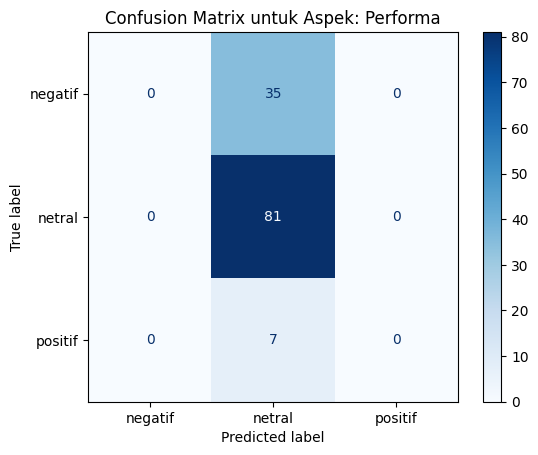

<Figure size 500x400 with 0 Axes>

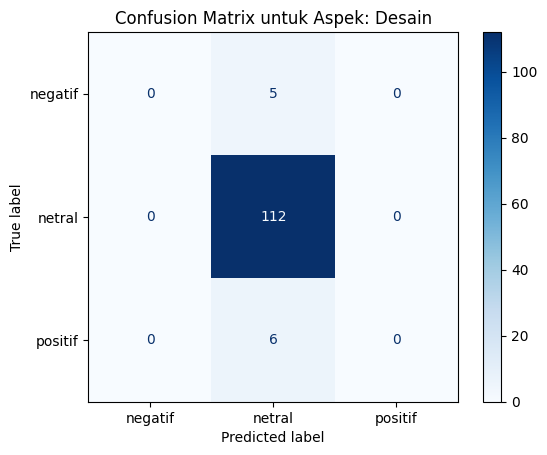

<Figure size 500x400 with 0 Axes>

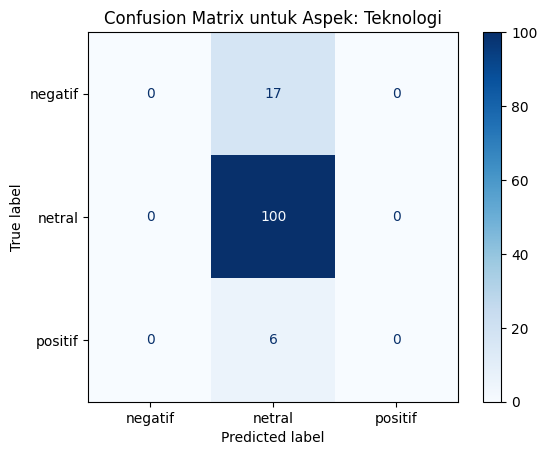

<Figure size 500x400 with 0 Axes>

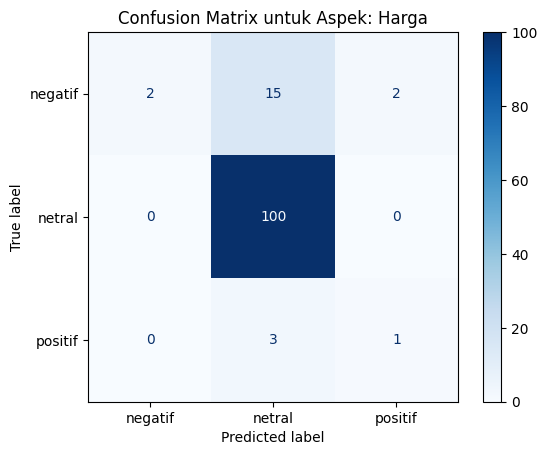

<Figure size 500x400 with 0 Axes>

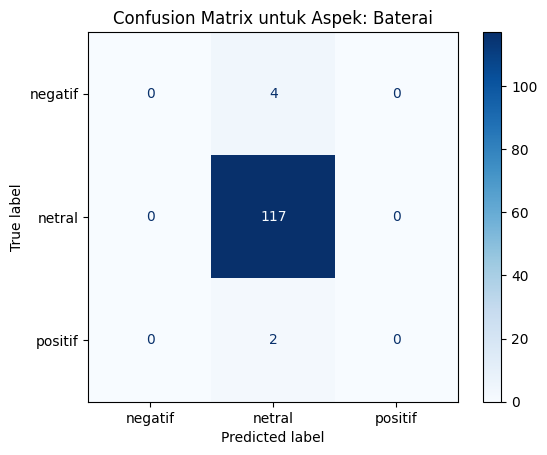

<Figure size 500x400 with 0 Axes>

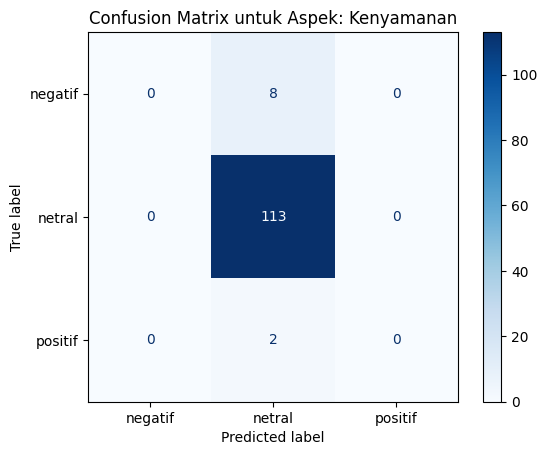

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay                   #(MENAMPILKAN CUNFUSHIN MATRIX )
import matplotlib.pyplot as plt
import pandas as pd # Import pandas

# Define aspects here, or ensure it's defined in a preceding cell that has been run
aspects = ['performa', 'desain', 'teknologi', 'harga', 'baterai', 'kenyamanan']

# Assuming df_pred DataFrames are available from previous steps
# If not, you'll need to load or create them here.
# For example, loading from 'pred.csv' and your original test labels
# Assuming df_pred was saved as a multi-column DataFrame in the previous step (cell 5UGemyV7VPgL)
try:
    df_pred = pd.read_csv('pred.csv')
except FileNotFoundError:
    print("Error: pred.csv not found. Please ensure the prediction cell was run and saved the file.")
    # You might want to handle this error more gracefully, e.g., stop execution or use dummy data
    exit() # Exit if the file is not found

# Load the true labels (assuming test_dataset_path and AspectBasedSentimentAnalysisVinfastDataset are defined)
# We need the original test labels to compare against the predictions.
if 'AspectBasedSentimentAnalysisVinfastDataset' in globals() and 'test_dataset_path' in globals():
    try:
        # Re-initialize the test dataset to get the original labels
        test_dataset_for_true_labels = AspectBasedSentimentAnalysisVinfastDataset(test_dataset_path, tokenizer, lowercase=True)
        df_true = test_dataset_for_true_labels.data[aspects].copy() # Select only the aspect columns and create a copy
    except Exception as e:
        print(f"Error loading true labels: {e}")
        exit()
else:
    print("Error: test_dataset_path or AspectBasedSentimentAnalysisVinfastDataset not defined. Cannot load true labels.")
    exit()


for aspect in aspects:
    y_true = df_true[aspect]
    y_pred = df_pred[aspect]

    # Ensure the labels used in confusion matrix cover all possible values in y_true and y_pred
    # The labels in the dataset are integers (0, 1, 2). The predictions are strings ('negatif', 'netral', 'positif').
    # We need to convert them to a common format. Let's convert predictions back to integers using the mapping.
    # If df_pred loaded strings, convert them to integers
    if isinstance(y_pred.iloc[0], str):
         # Access the mapping from the dataset class
         label_to_index = test_dataset_for_true_labels.LABEL2INDEX
         y_pred_int = y_pred.map(label_to_index)
    else:
         y_pred_int = y_pred # Assume it's already integer if not string

    # Ensure y_true is also integer
    if isinstance(y_true.iloc[0], str):
         # Access the mapping from the dataset class
         label_to_index = test_dataset_for_true_labels.LABEL2INDEX
         y_true_int = y_true.map(label_to_index)
    else:
         y_true_int = y_true # Assume it's already integer if not string


    # Define the labels for the confusion matrix using the integer mapping
    # We need to sort the labels if we want a consistent matrix order
    # Let's use the string labels for display, but integer labels for the matrix calculation
    cm_labels_int = sorted(test_dataset_for_true_labels.LABEL2INDEX.values()) # [0, 1, 2]
    cm_display_labels_str = [test_dataset_for_true_labels.INDEX2LABEL[i] for i in cm_labels_int] # ['negatif', 'netral', 'positif']


    # Compute confusion matrix using integer labels
    cm = confusion_matrix(y_true_int, y_pred_int, labels=cm_labels_int)
    # Use string labels for display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_display_labels_str)

    plt.figure(figsize=(5, 4))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix untuk Aspek: {aspect.capitalize()}')
    plt.grid(False)
    plt.show()

In [ ]:
from sklearn.metrics import classification_report  #(MENGHASILKAN LAPORAN EVALUASI)
import pandas as pd # Import pandas

# Define aspects here, or ensure it's defined in a preceding cell that has been run
aspects = ['performa', 'desain', 'teknologi', 'harga', 'baterai', 'kenyamanan']

# Load the true labels (assuming df_true was loaded in the previous cell)
# If not, you'll need to load it again.
try:
    # Assuming AspectBasedSentimentAnalysisVinfastDataset is defined and test_dataset_path is available
    test_dataset_for_true_labels = AspectBasedSentimentAnalysisVinfastDataset('data_mobil_test.csv', tokenizer, lowercase=True)
    df_true = test_dataset_for_true_labels.data[aspects].copy() # Select only the aspect columns and create a copy
except NameError:
     print("Error: test_dataset_path or AspectBasedSentimentAnalysisVinfastDataset not defined. Cannot load true labels.")
     exit()

# Load the predicted labels (assuming df_pred was loaded in the previous cell)
# If not, you'll need to load it again.
try:
    df_pred = pd.read_csv('pred.csv')
except FileNotFoundError:
    print("Error: pred.csv not found. Please ensure the prediction cell was run and saved the file.")
    exit()

for aspect in aspects:
    y_true = df_true[aspect]
    y_pred = df_pred[aspect]

    # Convert predicted string labels to integers using the mapping
    # Ensure the mapping object is accessible (e.g., from the dataset class)
    try:
        # Access the mapping from the dataset class
        label_to_index = AspectBasedSentimentAnalysisVinfastDataset.LABEL2INDEX
        y_pred_int = y_pred.map(label_to_index)
    except NameError:
        print("Error: AspectBasedSentimentAnalysisVinfastDataset or LABEL2INDEX not defined. Cannot convert predicted labels.")
        exit()

    # Ensure y_true is also integer (it should be from the dataset loading)
    # Add a check just in case
    if isinstance(y_true.iloc[0], str):
         y_true_int = y_true.map(label_to_index)
    else:
         y_true_int = y_true

    # Define the labels for the classification report using the integer mapping
    # Explicitly provide all possible labels to handle cases where not all labels are present in the data
    cm_labels_int = sorted(label_to_index.values()) # [0, 1, 2]
    target_names = [AspectBasedSentimentAnalysisVinfastDataset.INDEX2LABEL[i] for i in cm_labels_int] # ['negatif', 'netral', 'positif']


    print(f"=== Classification Report untuk Aspek: {aspect.capitalize()} ===")
    # Use integer labels for classification_report and specify the labels parameter
    print(classification_report(y_true_int, y_pred_int, labels=cm_labels_int, target_names=target_names, zero_division=0))
    print()

=== Classification Report untuk Aspek: Performa ===
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00        35
      netral       0.66      1.00      0.79        81
     positif       0.00      0.00      0.00         7

    accuracy                           0.66       123
   macro avg       0.22      0.33      0.26       123
weighted avg       0.43      0.66      0.52       123


=== Classification Report untuk Aspek: Desain ===
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00         5
      netral       0.91      1.00      0.95       112
     positif       0.00      0.00      0.00         6

    accuracy                           0.91       123
   macro avg       0.30      0.33      0.32       123
weighted avg       0.83      0.91      0.87       123


=== Classification Report untuk Aspek: Teknologi ===
              precision    recall  f1-score   support

     negatif       0.00   

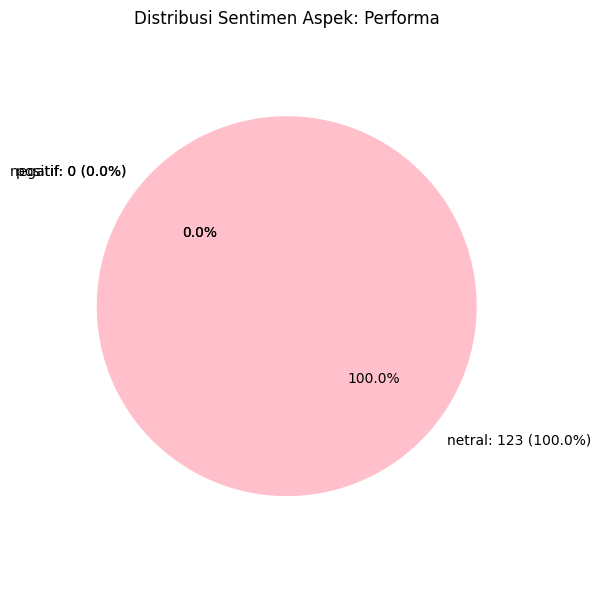

--- Jumlah Sentimen untuk Aspek: Performa ---
Positif: 0 data (0.0%)
Netral: 123 data (100.0%)
Negatif: 0 data (0.0%)
Total Data: 123
--------------------------------------------------


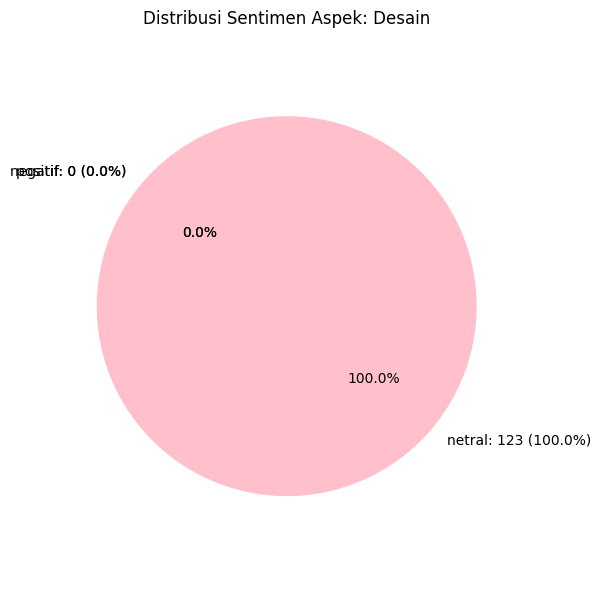

--- Jumlah Sentimen untuk Aspek: Desain ---
Positif: 0 data (0.0%)
Netral: 123 data (100.0%)
Negatif: 0 data (0.0%)
Total Data: 123
--------------------------------------------------


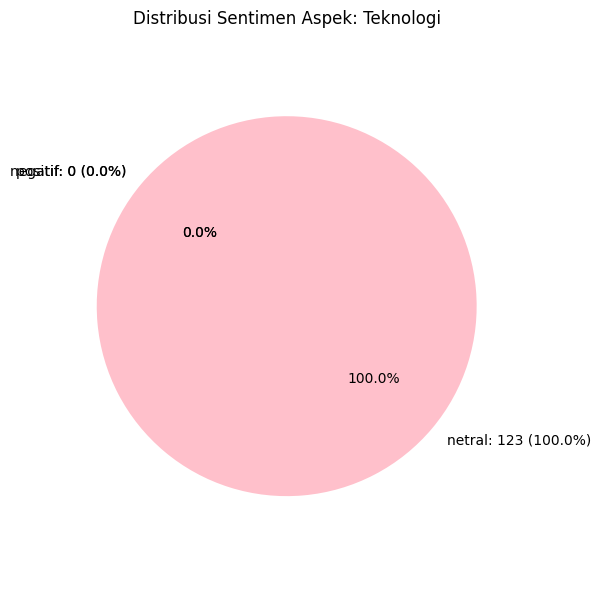

--- Jumlah Sentimen untuk Aspek: Teknologi ---
Positif: 0 data (0.0%)
Netral: 123 data (100.0%)
Negatif: 0 data (0.0%)
Total Data: 123
--------------------------------------------------


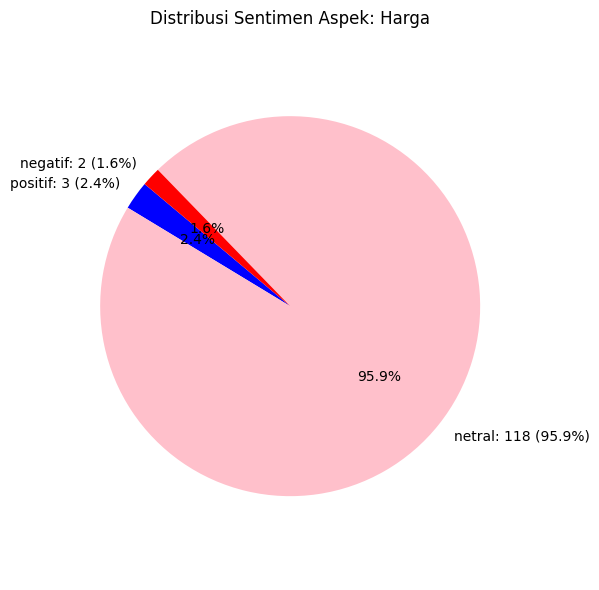

--- Jumlah Sentimen untuk Aspek: Harga ---
Positif: 3 data (2.4%)
Netral: 118 data (95.9%)
Negatif: 2 data (1.6%)
Total Data: 123
--------------------------------------------------


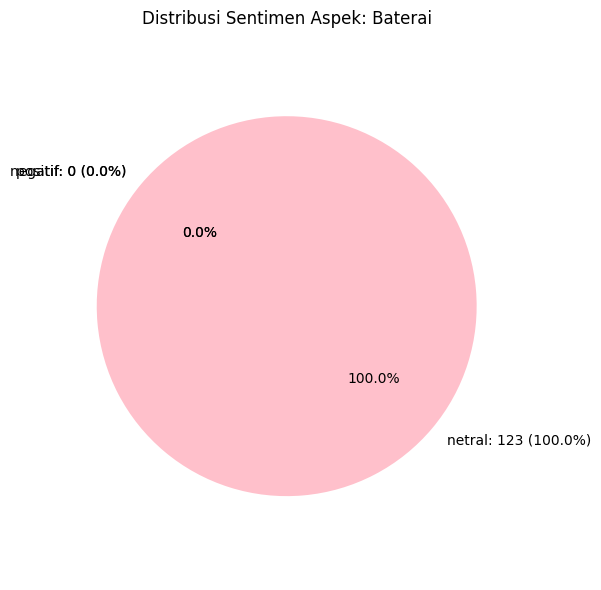

--- Jumlah Sentimen untuk Aspek: Baterai ---
Positif: 0 data (0.0%)
Netral: 123 data (100.0%)
Negatif: 0 data (0.0%)
Total Data: 123
--------------------------------------------------


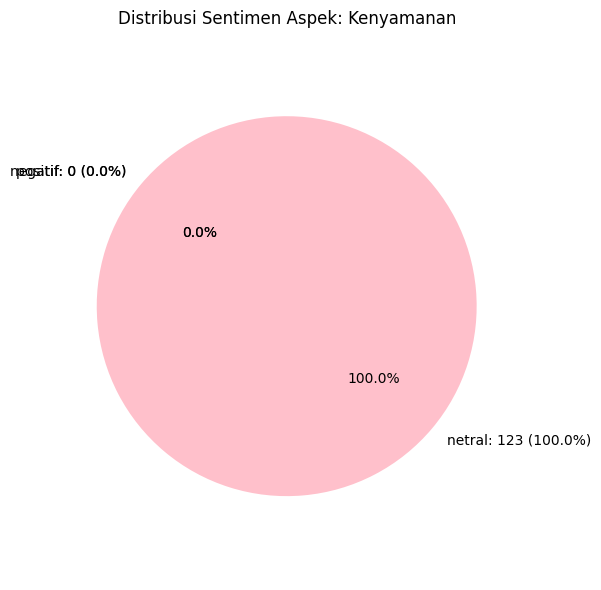

--- Jumlah Sentimen untuk Aspek: Kenyamanan ---
Positif: 0 data (0.0%)
Netral: 123 data (100.0%)
Negatif: 0 data (0.0%)
Total Data: 123
--------------------------------------------------


In [ ]:
import pandas as pd    #(MEMVISUALISASIKAN DISTRIBUSI SENTIMEN DALAM BENTUK PIE CHART PER ASPEK)
import matplotlib.pyplot as plt

# Daftar aspek yang dianalisis
aspects = ['performa', 'desain', 'teknologi', 'harga', 'baterai', 'kenyamanan']

# DataFrame prediksi model
df_pred = pd.DataFrame(list_hyp, columns=aspects)

# Plot pie chart per aspek
for aspect in aspects:
    sentiment_counts = df_pred[aspect].value_counts().reindex(['positif', 'netral', 'negatif'], fill_value=0)

    # Hitung total dan persentase
    total = sentiment_counts.sum()
    labels = sentiment_counts.index.tolist()
    sizes = sentiment_counts.values
    percentages = [f"{label}: {count} ({count/total:.1%})" for label, count in zip(labels, sizes)]

    # Pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=percentages, autopct='%1.1f%%', startangle=140, colors=['blue', 'pink', 'red'])
    plt.title(f'Distribusi Sentimen Aspek: {aspect.capitalize()}')
    plt.axis('equal')  # Untuk membuat pie chart berbentuk lingkaran
    plt.tight_layout()
    plt.show()

    # Tampilkan data numerik
    print(f"--- Jumlah Sentimen untuk Aspek: {aspect.capitalize()} ---")
    for label in ['positif', 'netral', 'negatif']:
        print(f"{label.capitalize()}: {sentiment_counts[label]} data ({sentiment_counts[label]/total:.1%})")
    print(f"Total Data: {total}")
    print("-" * 50)


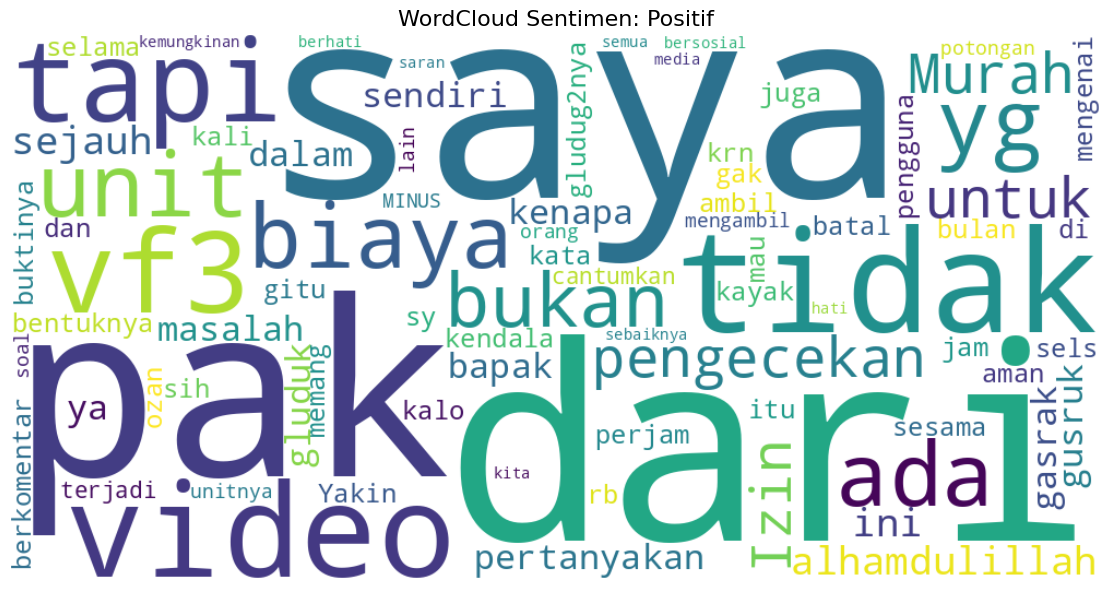

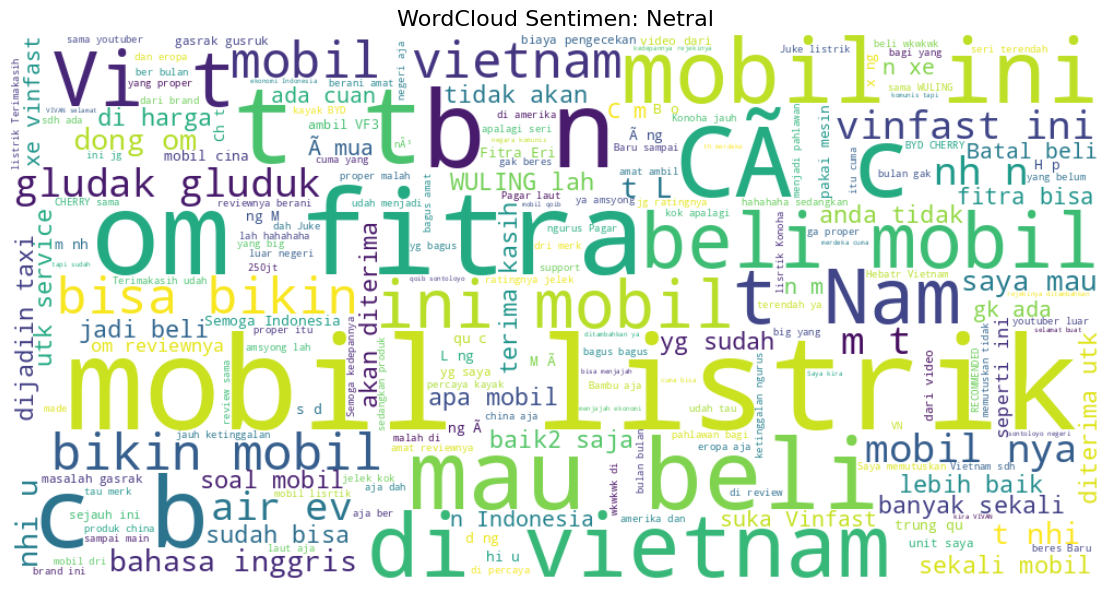

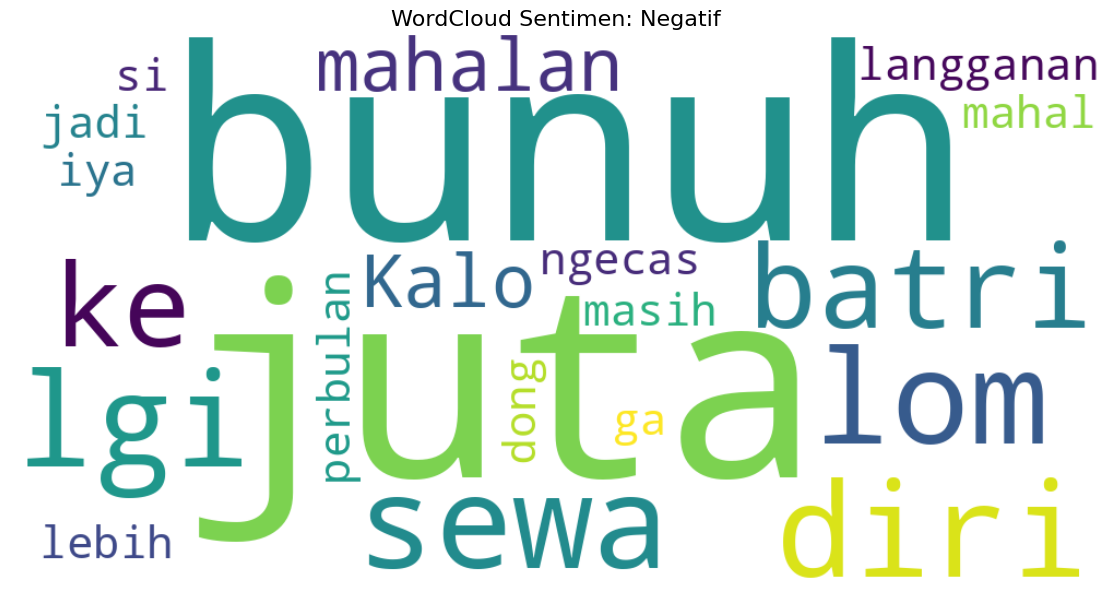

In [ ]:
from wordcloud import WordCloud         #(VISUALISASI WORDCLOUD)
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Pastikan test_dataset_path dan tokenizer sudah didefinisikan
try:
    test_dataset_for_wordcloud = AspectBasedSentimentAnalysisVinfastDataset(test_dataset_path, tokenizer, lowercase=True)
    df_asli = test_dataset_for_wordcloud.data
except NameError:
    print("Error: test_dataset_path atau Dataset class belum didefinisikan.")
    exit()

# Load hasil prediksi
try:
    df_pred = pd.read_csv('pred.csv')
except FileNotFoundError:
    print("Error: File 'pred.csv' tidak ditemukan.")
    exit()

# Gabungkan teks dan label sentimen dari semua aspek
df_combined = df_asli[['textDisplay']].copy()
for aspect in aspects:
    df_combined[f'label_{aspect}'] = df_pred[aspect]

# Kumpulan teks berdasarkan sentimen secara keseluruhan
sentiment_texts = defaultdict(str)

for sentiment in ['positif', 'netral', 'negatif']:
    for aspect in aspects:
        filtered = df_combined[df_combined[f'label_{aspect}'] == sentiment]
        combined_text = " ".join(filtered['textDisplay'].astype(str).tolist())
        sentiment_texts[sentiment] += combined_text

# Tampilkan WordCloud untuk tiap sentimen
for sentiment in ['positif', 'netral', 'negatif']:
    text = sentiment_texts[sentiment]
    if text.strip():
        wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(text)
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'WordCloud Sentimen: {sentiment.capitalize()}', fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Tidak ada teks tersedia untuk sentimen: {sentiment}")


In [ ]:
text = 'gk import mobil ev gk cuan mobil negri gk kasih lancar gk cuan selagi l maih hidup gk tranportasi merk indonesia'
subwords = tokenizer.encode(text)                                                  #(MEMPREDIKSI SENTIMENYANG SUDAH DI FINE TUNE)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
labels = [torch.topk(logit, k=1, dim=-1)[1].squeeze().item() for logit in logits]

print(f'Text: {text}')
for i, label in enumerate(labels):
    print(f'Label `{AspectBasedSentimentAnalysisVinfastDataset.ASPECT_DOMAIN[i]}` : {i2w[label]} ({F.softmax(logits[i], dim=-1).squeeze()[label] * 100:.3f}%)')

Text: gk import mobil ev gk cuan mobil negri gk kasih lancar gk cuan selagi l maih hidup gk tranportasi merk indonesia
Label `performa` : netral (99.223%)
Label `desain` : netral (98.948%)
Label `teknologi` : netral (98.958%)
Label `harga` : netral (98.641%)
Label `baterai` : netral (99.379%)
Label `kenyamanan` : netral (99.321%)


In [ ]:
text = 'Kalo langganan masih ngecas perbulan jadi lebih mahal dong iya ga si'            #(MEMPREDIKSI SENTIMEN DARI KOMENTAR)
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
labels = [torch.topk(logit, k=1, dim=-1)[1].squeeze().item() for logit in logits]

print(f'Text: {text}')
for i, label in enumerate(labels):
    print(f'Label `{AspectBasedSentimentAnalysisVinfastDataset.ASPECT_DOMAIN[i]}` : {i2w[label]} ({F.softmax(logits[i], dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Kalo langganan masih ngecas perbulan jadi lebih mahal dong iya ga si
Label `performa` : netral (95.516%)
Label `desain` : netral (96.177%)
Label `teknologi` : netral (96.003%)
Label `harga` : negatif (41.803%)
Label `baterai` : netral (96.938%)
Label `kenyamanan` : netral (97.981%)


In [ ]:
# Load the original test dataset to get the raw text                               #(MEMUAT DATA SET UJI)
# Assuming test_dataset_path is defined and the dataset class loads the data into a pandas DataFrame
test_dataset_for_wordcloud = AspectBasedSentimentAnalysisVinfastDataset(test_dataset_path, tokenizer, lowercase=True)
df_asli = test_dataset_for_wordcloud.data

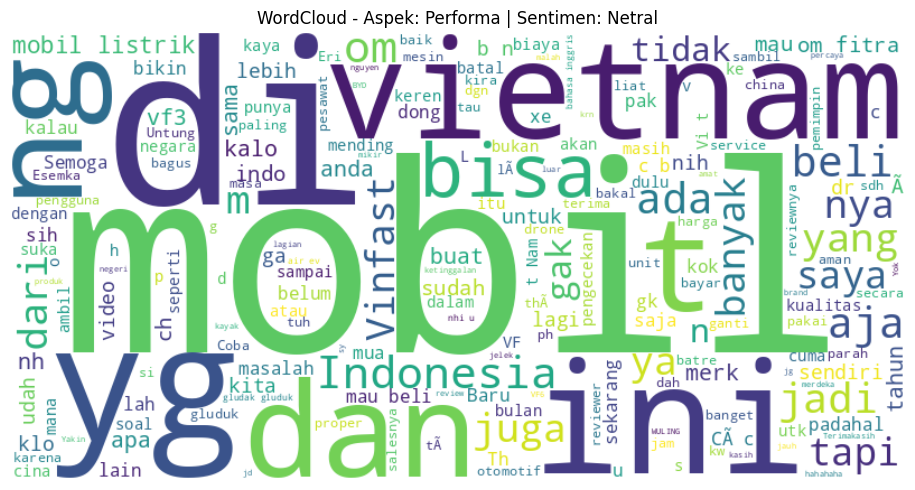

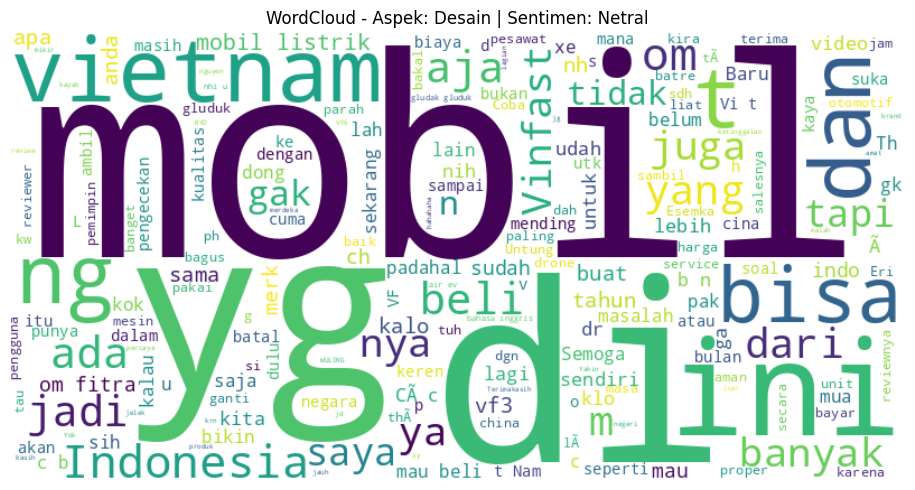

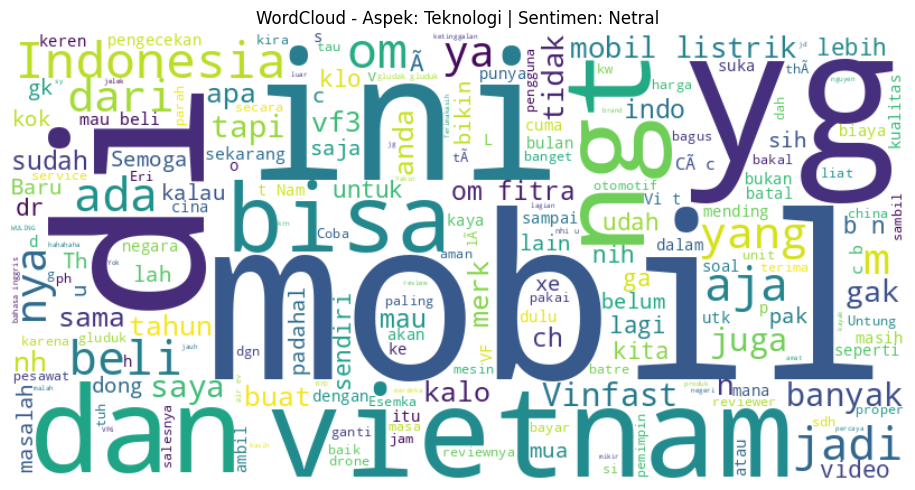

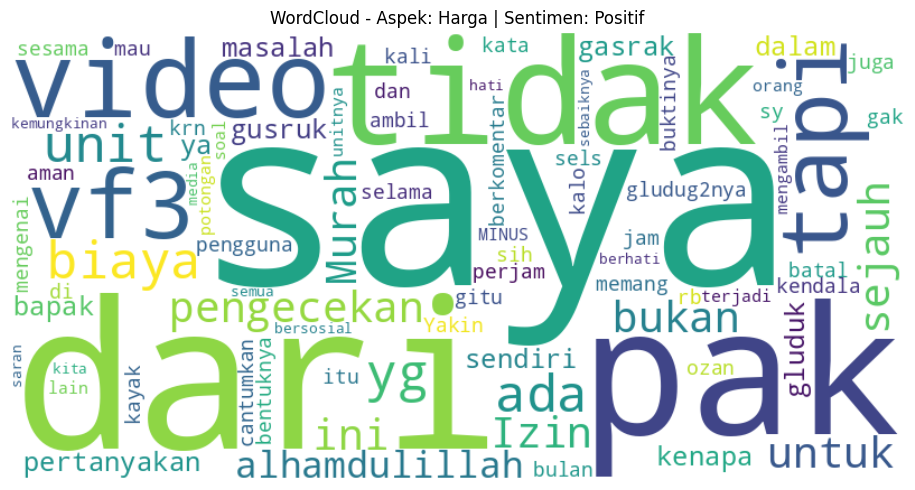

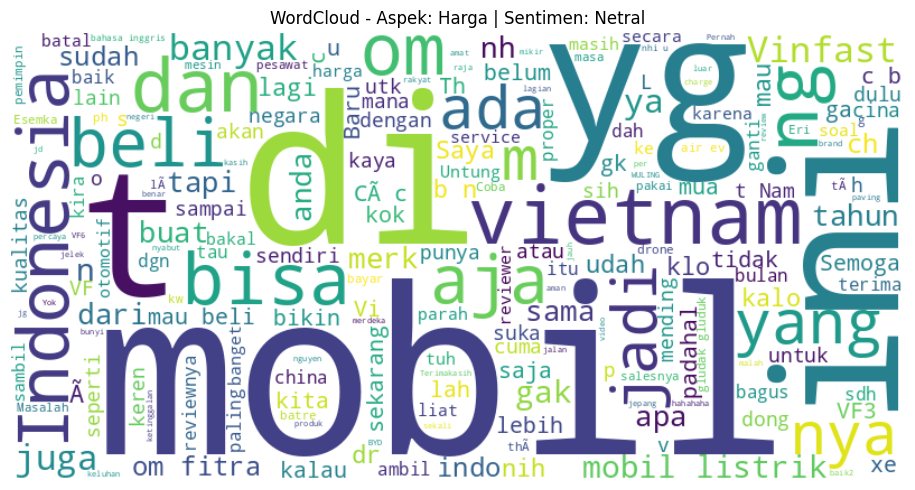

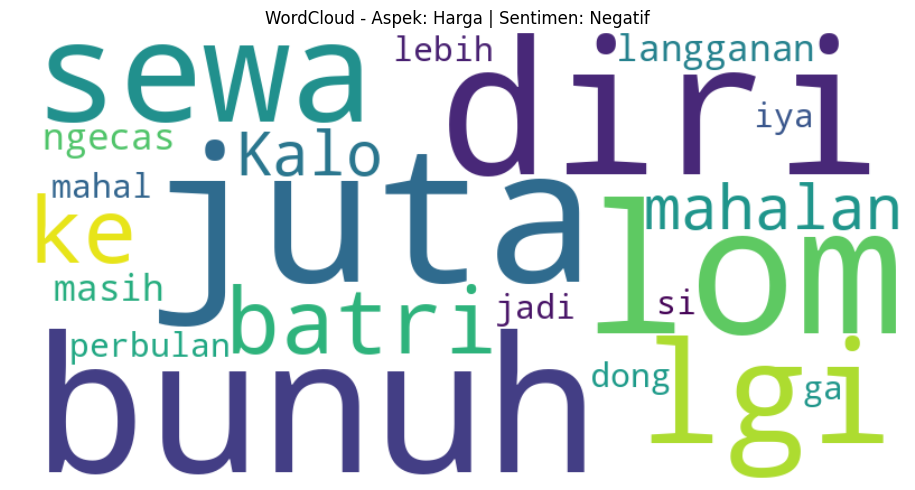

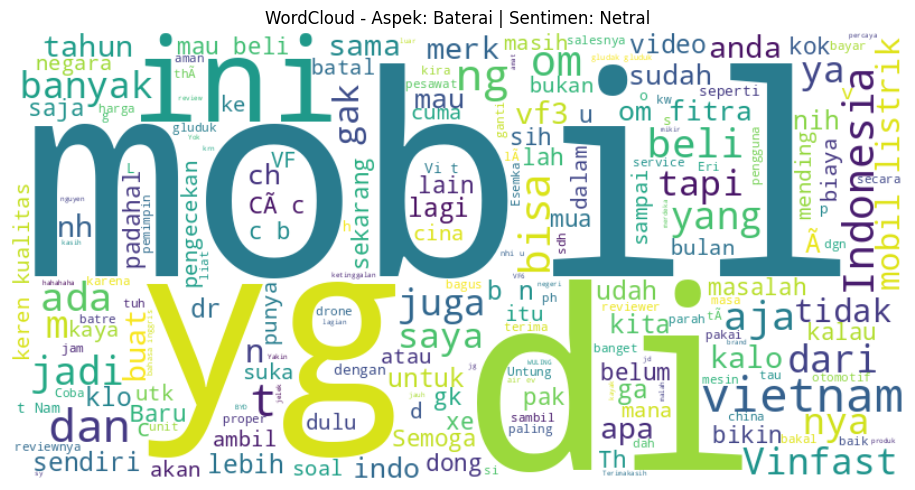

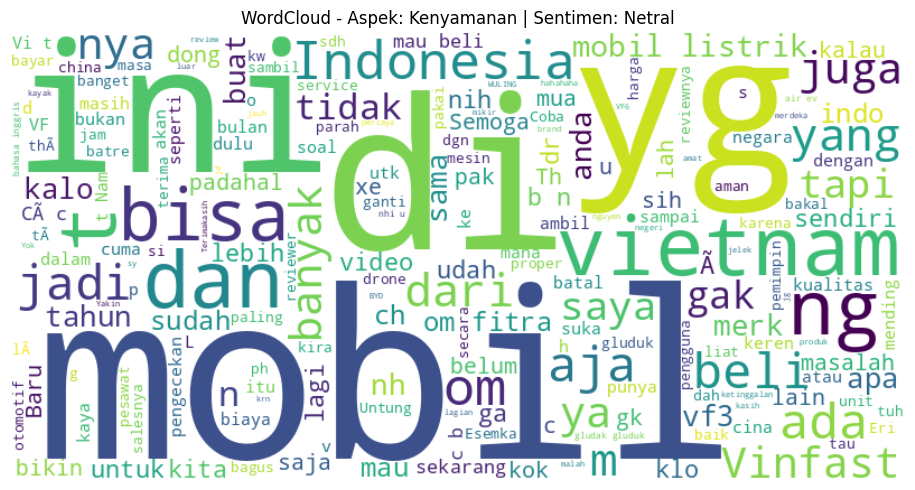

In [ ]:
from wordcloud import WordCloud              #(MEMBUAT WORD CLOUD UNTUK SETIAP ASPEK DAN KATEGORI SENTIMEN)
from collections import defaultdict

# Misal: df_asli punya kolom 'textDisplay'
# df_pred punya prediksi aspek
# df_asli.index harus cocok dengan df_pred.index
# Gabungkan teks asli dan prediksi
df_combined = df_asli[['textDisplay']].copy()
for aspect in aspects:
    df_combined[f'label_{aspect}'] = df_pred[aspect]

# Buat kumpulan teks per (aspek, sentimen)
aspect_sentiment_texts = defaultdict(str)

for aspect in aspects:
    for sentiment in ['positif', 'netral', 'negatif']:
        filtered = df_combined[df_combined[f'label_{aspect}'] == sentiment]
        combined_text = " ".join(filtered['textDisplay'].astype(str).tolist())
        aspect_sentiment_texts[(aspect, sentiment)] += combined_text

# Tampilkan WordCloud per aspek dan sentimen
for aspect in aspects:
    for sentiment in ['positif', 'netral', 'negatif']:
        text = aspect_sentiment_texts[(aspect, sentiment)]
        if text.strip():  # Cek apakah teks tidak kosong
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'WordCloud - Aspek: {aspect.capitalize()} | Sentimen: {sentiment.capitalize()}')
            plt.tight_layout()
            plt.show()


Tidak ada teks untuk sentimen: Positif


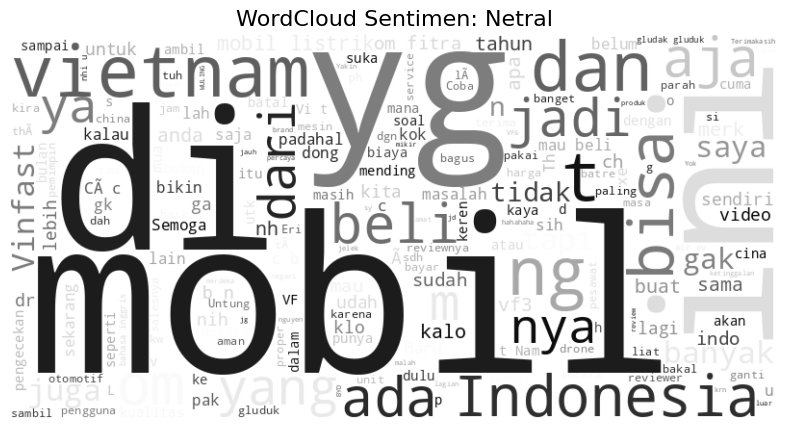

Tidak ada teks untuk sentimen: Negatif


In [ ]:
from wordcloud import WordCloud #(MEMBUAT WORDCLUD BERDASARKAN SENTIMEN DOMINAN GUNA MELIHAT KATA KATA YANG SERING MUNCUL)
import matplotlib.pyplot as plt

# Pastikan kamu punya DataFrame df_test dengan kolom 'text' dan df_pred (hasil prediksi) berisi label sentimen
# Gabungkan teks dengan label sentimen rata-ratanya

# Asumsikan list_hyp adalah prediksi sentimen multi-label ['positif', 'netral', 'negatif'] untuk masing-masing aspek
# Langkah: ambil sentimen mayoritas per baris (komentar)

import pandas as pd

# Buat DataFrame dari prediksi multi-label
df_pred = pd.DataFrame(list_hyp, columns=['performa', 'desain', 'teknologi', 'harga', 'baterai', 'kenyamanan'])

# Ambil rata-rata label per baris (frekuensi kemunculan sentimen), lalu ambil sentimen yang paling dominan
def get_majority_sentiment(row):
    # Hitung frekuensi setiap sentimen dalam satu baris
    sentiment_counts = row.value_counts()
    # Ambil sentimen dengan frekuensi tertinggi. Jika ada tie, ambil yang pertama muncul.
    return sentiment_counts.idxmax()

# Gunakan df_asli yang sudah dimuat dan kolom 'textDisplay'
# Pastikan index df_asli dan df_pred sesuai
df_asli['sentimen_dominan'] = df_pred.apply(get_majority_sentiment, axis=1)


# Gabungkan teks berdasarkan sentimen dominan
sentimen_text = {
    label: ' '.join(df_asli[df_asli['sentimen_dominan'] == label]['textDisplay'].astype(str).tolist())
    for label in ['positif', 'netral', 'negatif']
}

# Atur font untuk Bahasa Indonesia (opsional)
# font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"  # Atau sesuaikan dengan font di sistem kamu

# Buat dan tampilkan WordCloud per sentimen
for label, text in sentimen_text.items():
    if text.strip(): # Hanya buat wordcloud jika ada teks
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                            colormap='Greens' if label == 'positif' else 'gray' if label == 'netral' else 'Reds'
                            ).generate(text) # Removed font_path argument

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'WordCloud Sentimen: {label.capitalize()}', fontsize=16)
        plt.show()
    else:
        print(f"Tidak ada teks untuk sentimen: {label.capitalize()}")